In [137]:
import os
from glob import glob
import pickle

import numpy as np
import pandas as pd

import nltk
import re
import codecs
import unidecode
#pip install unidecode
import mpld3
# pip install mpld3
import stop_words
# pip install stop-words
from nltk import SnowballStemmer, pos_tag, word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords

from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import HashingVectorizer,TfidfTransformer,TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import *
from sklearn.linear_model import LogisticRegression
from sklearn.svm import *
#from sklearn.semi_supervised import *
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import metrics
import itertools
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve, auc


** Lecture des données **

In [2]:
#download cv in a list
def load_cv_list(nombre):
    path = '../Maha/data/Txt/'
    liste_paths = [path+directory for directory in os.listdir(path)]
    liste_cv = []
    liste_files = []
    for path in liste_paths :
        #if "informaticien" and "dba" and "chef_de_projet_informatique" not in path:
        filenames = sorted(glob(os.path.join(path,"*.txt")))
           
        for file in filenames[:nombre]:
            liste_cv.append(open(file).read())
            liste_files.append(file)
    return liste_cv,liste_files

In [3]:
liste_cv_indeed,liste_files = load_cv_list(700)

In [4]:
print(len(liste_cv_indeed), "cvs")

6452 cvs


In [5]:
liste_files_sub = [cvName.split('/')[-1][0:-4] for cvName in liste_files  ]
cv_names = liste_files_sub
print(len(cv_names),"cv names")


6452 cv names


In [6]:
liste_cv_indeed[0]

"Administrateur réseaux et sécurité\n\nNanterre (92) - Email me on Indeed: indeed.com/r/38feb844e66fc577\n\nEXPÉRIENCE\n\nAdministrateur réseaux et sécurité\n\nIT Delivery Services  -  Paris (75) -\n\naoût 2017 - novembre 2017\n\nIT Delivery Services – Administrateur Réseau et Sécurité\nParis\nMission chez ATOS : Administration des Pare-feu (Fortigate 5000 et 1500)\n〓 Piloter un projet de migration de 70 VDOM\n〓 Etude de l’existant et préparation des schémas cible\n〓 Création de la matrice de flux\n〓 Mettre en place un plan d’adressage, VLAN et Routage\n〓 Upgrade des FortiOS\n〓 Analyse et comparaison les fichiers de configuration\n〓 Résolution des problèmes technique.\n〓 Analyse de risque et création des modes opératoires de Migration\n\nAdministrateur systèmes, réseaux et virtualisation\n\nAtento (Intelcia)  -  Casablanca -\n\nnovembre 2006 - mai 2017\n\n-Réseau (Switch, Routeur, firewall) (Cisco, Dell, HP, Fortigate, Peplink)\n〓 Configuration et attribution des adresses IP, VLAN, VPN

In [7]:
# Read CV labels 
def read_labels(fileName):
    xl = pd.ExcelFile(fileName)
    df_labels = xl.parse("Feuil1")
    print("Nb of labeled CV", df_labels[df_labels['CV_Label']!=-1].count())
    print("Nb of unlabeled CV", df_labels[df_labels['CV_Label']==-1].count())
    print("Total Nb of CV ", df_labels.count())
    return df_labels


In [8]:
df_labels = read_labels('./Data_label/indeed/CV_labels.xlsx')
df_labels

Nb of labeled CV CV_name     121
CV_Label    121
dtype: int64
Nb of unlabeled CV CV_name     133
CV_Label    133
dtype: int64
Total Nb of CV  CV_name     254
CV_Label    254
dtype: int64


,CV_name,CV_Label
0,cv_Administrateur Base Donnees_1,2
1,cv_Administrateur Base Donnees_2,2
2,cv_Administrateur Base Donnees_3,1
3,cv_Administrateur Base Donnees_4,1
4,cv_Administrateur Base Donnees_5,1
5,cv_Administrateur Base Donnees_6,2
6,cv_Administrateur Base Donnees_7,2
7,cv_Administrateur Base Donnees_8,-1
8,cv_Administrateur Base Donnees_9,2
9,cv_Administrateur Base Donnees_10,2


### Cleaning fonctions

#### Suppression des sauts de ligne

In [9]:
import string,re

In [10]:
regex = re.compile('[%s]' % '(\\n)*(\\x0c)*')
def del_line_feed(s):  
    """Delete \n in the text"""
    return regex.sub(' ', s)

In [11]:
liste_cv_indeed = [del_line_feed(text).lower() for text in liste_cv_indeed]

In [12]:
liste_cv_indeed[0]

"administrateur réseaux et sécurité  nanterre  92  - email me on indeed: indeed.com/r/38feb844e66fc577  expérience  administrateur réseaux et sécurité  it delivery services  -  paris  75  -  août 2017 - novembre 2017  it delivery services – administrateur réseau et sécurité paris mission chez atos : administration des pare-feu  fortigate 5000 et 1500  〓 piloter un projet de migration de 70 vdom 〓 etude de l’existant et préparation des schémas cible 〓 création de la matrice de flux 〓 mettre en place un plan d’adressage, vlan et routage 〓 upgrade des fortios 〓 analyse et comparaison les fichiers de configuration 〓 résolution des problèmes technique. 〓 analyse de risque et création des modes opératoires de migration  administrateur systèmes, réseaux et virtualisation  atento  intelcia   -  casablanca -  novembre 2006 - mai 2017  -réseau  switch, routeur, firewall   cisco, dell, hp, fortigate, peplink  〓 configuration et attribution des adresses ip, vlan, vpn  ssl & ipsec , stp, vrrp, rout

#### Suppression ponctuation

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
#le maintient de la ponctuation pertube le stop words, apostrophe gérée dans text_treatment
regex = re.compile('[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_{|}~')) 

def del_punct(s):  
    """Delete punctuation in the text"""
    return regex.sub('', s)

In [15]:
#test 
liste_cv_indeed_no_punc = [del_punct(text) for text in liste_cv_indeed]

In [16]:
liste_cv_indeed_no_punc[0]

"administrateur réseaux et sécurité  nanterre  92   email me on indeed indeedcomr38feb844e66fc577  expérience  administrateur réseaux et sécurité  it delivery services    paris  75    août 2017  novembre 2017  it delivery services – administrateur réseau et sécurité paris mission chez atos  administration des parefeu  fortigate 5000 et 1500  〓 piloter un projet de migration de 70 vdom 〓 etude de l’existant et préparation des schémas cible 〓 création de la matrice de flux 〓 mettre en place un plan d’adressage vlan et routage 〓 upgrade des fortios 〓 analyse et comparaison les fichiers de configuration 〓 résolution des problèmes technique 〓 analyse de risque et création des modes opératoires de migration  administrateur systèmes réseaux et virtualisation  atento  intelcia     casablanca   novembre 2006  mai 2017  réseau  switch routeur firewall   cisco dell hp fortigate peplink  〓 configuration et attribution des adresses ip vlan vpn  ssl  ipsec  stp vrrp routage  statique et dynamique  n

** Reconnaissance du langage du CV**

In [17]:
def _calculate_languages_ratios(text):
    """
    Calculate probability of given text to be written in several languages and
    return a dictionary that looks like {'french': 2, 'spanish': 4, 'english': 0}
    """

    languages_ratios = {}

    '''
    nltk.wordpunct_tokenize() splits all punctuations into separate tokens
    
    >>> wordpunct_tokenize("That's thirty minutes away. I'll be there in ten.")
    ['That', "'", 's', 'thirty', 'minutes', 'away', '.', 'I', "'", 'll', 'be', 'there', 'in', 'ten', '.']
    '''

    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens] #from text get list of word in minuscule

    
    for language in stopwords.fileids(): # pour chaque langue
        stopwords_set = set(stopwords.words(language)) #je mets les stop words du langage dans un set
        words_set = set(words) #je mets les mots de mon texte dans un set
        #je prends l'intersection entre les mots de mon texte et les mots du stopwords dans le langage donné
        common_elements = words_set & stopwords_set
        
        #je compute mon score comme le nombre d'éléments en communs dictionnaire [langage : score]
        languages_ratios[language] = len(common_elements) # language "score"

    return languages_ratios

In [18]:
import nltk
nltk.download('stopwords')
stopwords.fileids()

[nltk_data] Downloading package stopwords to /Users/maha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['arabic',
 'azerbaijani',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'spanish',
 'swedish',
 'turkish']

In [19]:
def get_cv_langue(liste_cv, language,cv_names) :
    """Return resume witten in the specified language in parameter"""
    liste_2 = []
    french_cv_names = []
    i=0
    for cv in liste_cv:
        if max(_calculate_languages_ratios(cv),key =_calculate_languages_ratios(cv).get)=='french':
            liste_2.append(cv)
            french_cv_names.append(cv_names[i])
        i+=1
    return liste_2,french_cv_names

In [20]:
liste_cv_indeed_fr, cv_fr_names = get_cv_langue(liste_cv_indeed_no_punc,'french',cv_names)

In [21]:
nb_cv = len(liste_cv_indeed_no_punc)
nb_cv_fr = len(liste_cv_indeed_fr)

print("proportion cv french :",1- ((nb_cv-nb_cv_fr)/nb_cv))


proportion cv french : 0.736515809051457


** Preprocessing du text **

In [22]:
def text_treatment (text):
    text = text.lower()
    text = text.replace("\x00", '').replace("\x01", '').replace("\x02", '').replace("\x03", '') \
    .replace("\x04", '').replace("\x05", '').replace("\x06", '').replace("\x07", '').replace("\x08", '') \
    .replace("\x0e", '').replace("\x11", '').replace("\x12", '').replace("\x10", '').replace("\x19", '') \
    .replace("\x1b", '').replace("\x14", '').replace("\x15", '').replace('/', '').replace('=', '').replace("〓", "") \
    .replace("»", "").replace("«", "").replace("¬", "").replace('`', '').replace (" -", "").replace("•", "")\
    .replace("l'", "").replace("l’", "").replace("l´", "").replace("d’", "").replace("d'", "").replace("d´","")\
    .replace("j’", "").replace("j'", "").replace("j´","").replace("n’", "").replace("n'", "").replace("n´","")\
    .replace("”", "").replace("~", "").replace("§", "").replace("¨", "").replace("©", "").replace("›", "")\
    .replace("₋", "").replace("→", "").replace("⇨", "").replace("∎", "").replace("√", "").replace("□", "")\
    .replace("*", "").replace("&", "").replace("►", "").replace("◊", "").replace("☞", "").replace("#", "")\
    .replace("%", "").replace("❖", "").replace("➠", "").replace("➢", "").replace("", "").replace("✓", "") \
    .replace("√", "").replace("✔", "").replace("♦", "").replace("◦", "").replace("●", "").replace("▫", "")\
    .replace("▪", "").replace("…", "").replace("þ", "").replace("®", "").replace('', '').replace("...", "")
    text = unidecode.unidecode(text) # remove accent
    return text

In [23]:
#On supprime les caractères étranges, accents et stop words
liste_cv_indeed_treated = [text_treatment(text) for text in liste_cv_indeed_fr]

In [24]:
#test
liste_cv_indeed_treated[0]

'administrateur reseaux et securite  nanterre  92   email me on indeed indeedcomr38feb844e66fc577  experience  administrateur reseaux et securite  it delivery services    paris  75    aout 2017  novembre 2017  it delivery services - administrateur reseau et securite paris mission chez atos  administration des parefeu  fortigate 5000 et 1500   piloter un projet de migration de 70 vdom  etude de existant et preparation des schemas cible  creation de la matrice de flux  mettre en place un plan adressage vlan et routage  upgrade des fortios  analyse et comparaison les fichiers de configuration  resolution des problemes technique  analyse de risque et creation des modes operatoires de migration  administrateur systemes reseaux et virtualisation  atento  intelcia     casablanca   novembre 2006  mai 2017  reseau  switch routeur firewall   cisco dell hp fortigate peplink   configuration et attribution des adresses ip vlan vpn  ssl  ipsec  stp vrrp routage  statique et dynamique  nat et les acl

** Gestion des stop words **

In [25]:
#generate stopwords
stop_words_py = set(stop_words.get_stop_words('french'))

# attention certains stop words pourraient être utiles par la suite
stopwords_set_manuel = set(["an", "ans", 'les', 'moins', 'd\'un','janvier', 'fevrier', 'février', 'mars', 'avril', \
                 'mai', 'juin', 'juillet', 'aout', 'août', 'septembre', 'octobre', 'novembre', 'décembre', \
                  'decembre', 'moins', 'mise', 'universit\xc3\xa9', 'université', 'universite', 'ion','sage', \
                  'o', 'rac', 'vers', 'via', 'p\xc3\xa9rim\xc3\xa8tre', 'périmètre','et','paris','x',"\x00",\
                          "\x01","\x02", "\x03","\x04","\x05","\x06","\x07","\x08","\x09","\x0e","\x0e","\x11",\
                           "\x12","\x13","\x14","\x15","\x16","\x17","\x18","\x19","transport","puis","lieu",\
                           "adresse","entre",'dun','dune','chez','boulognebillancourt','bt','etc','recrutement','main',\
                           'and', 'paie','paiement','environ','place','france','paris','mois','mobile','mobiles',\
                           'nanterre','source','sources','concerne','concernant','of','non','notes','rh','minimum',\
                           'maximum','bac','site','sites','actuellement','telephone','telephonique','telephoniques','ca','demenager',\
                           'demenagement','participer','participation','lycee','baccalaureat','lien','liens','in',\
                           'indeed','email','indeedcomrd7e8913ed00d0384','aujourhui','afin','toujours','enterprise',\
                           "guide","10g","11g","9i",'ad','v10','v2','v3','v5','v6','v8','v9',])
stop_words_main = stop_words_py | stopwords_set_manuel
stop_words_main = list(stop_words_main)
print("taille stop words liste : ", len(stop_words_main))

taille stop words liste :  368


In [26]:
stop_words_main

['demenager',
 'ici',
 'eusses',
 'fûmes',
 'que',
 'aie',
 'eût',
 'cela',
 'ce',
 'ou',
 'vu',
 'ni',
 'nous',
 'votre',
 'ayant',
 'paiement',
 '\x16',
 'eu',
 'sont',
 'avant',
 'notre',
 'bt',
 'les',
 'fussions',
 't',
 'une',
 'périmètre',
 'sous',
 'telephoniques',
 'place',
 'devrait',
 'ayez',
 'décembre',
 'aurait',
 '\x17',
 'eussiez',
 'eurent',
 'ta',
 'guide',
 'seront',
 'en',
 'v10',
 'ses',
 'notes',
 'aux',
 'source',
 'parole',
 'font',
 'site',
 'puis',
 'v9',
 'x',
 'qui',
 'avons',
 'aurons',
 'mes',
 'quelles',
 'sites',
 'fus',
 'tous',
 'tu',
 'ça',
 'telephonique',
 'universite',
 'juillet',
 'il',
 'vont',
 'septembre',
 'y',
 'v2',
 'aussi',
 'sources',
 'ceux',
 '\x18',
 'telephone',
 'leur',
 'été',
 'transport',
 'aurai',
 'nommée',
 'dos',
 'aient',
 'faites',
 'mon',
 'même',
 'doit',
 'est',
 '\x01',
 'main',
 'depuis',
 'eue',
 'indeedcomrd7e8913ed00d0384',
 'deux',
 'maintenant',
 'serais',
 'toi',
 'lui',
 'auront',
 '10g',
 'peu',
 'où',
 'etc',
 

In [27]:
#voir si utile
def remove_stopwords(text,stopwords_list):
    text_temp = " ".join(text.split())+" "
    for word in stopwords_list:
        text_temp = text_temp.replace(" "+word+" ", " ")
    return text_temp

In [28]:
#test 
liste_cv_indeed_no_stop = [remove_stopwords(text,stop_words_main) for text in liste_cv_indeed_treated]

In [29]:
liste_cv_indeed_no_stop[0]

'administrateur reseaux securite 92 indeedcomr38feb844e66fc577 experience administrateur reseaux securite it delivery services 75 2017 2017 it delivery services - administrateur reseau securite mission atos administration parefeu fortigate 5000 1500 piloter projet migration 70 vdom etude existant preparation schemas cible creation matrice flux mettre plan adressage vlan routage upgrade fortios analyse comparaison fichiers configuration resolution problemes technique analyse risque creation modes operatoires migration administrateur systemes reseaux virtualisation atento intelcia casablanca 2006 2017 reseau switch routeur firewall cisco dell hp fortigate peplink configuration attribution adresses ip vlan vpn ssl ipsec stp vrrp routage statique dynamique nat acls supervision bande passante erreurs discards etat ports solarwinds application mises jour firmware administration coeur reseau cisco catalyste 4507 dell force10 c150 sauvegarde restauration configurations parametrage logs syslog 

In [30]:
#SnowballStemmer 
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("french")

In [31]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters 
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters 
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [32]:
totalvocab_indeed_stemmed = []
totalvocab_indeed_tokenized = []
for text in liste_cv_indeed_no_stop:
    allwords_stemmed = tokenize_and_stem(text) #for each item in 'synopses', tokenize/stem
    totalvocab_indeed_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    allwords_tokenized = tokenize_only(text)
    totalvocab_indeed_tokenized.extend(allwords_tokenized)

In [33]:
vocab_frame_indeed = pd.DataFrame({'words': totalvocab_indeed_tokenized}, index = totalvocab_indeed_stemmed)
print('there are ' + str(vocab_frame_indeed.shape[0]) + ' items in vocab_frame')
vocab_frame_indeed

there are 1003529 items in vocab_frame


,words
administr,administrateur
reseau,reseaux
securit,securite
indeedcomr38feb844e66fc577,indeedcomr38feb844e66fc577
experient,experience
administr,administrateur
reseau,reseaux
securit,securite
it,it
delivery,delivery


In [34]:
vocab_frame_indeed.loc['in']

,words
in,ins
in,ins


HashVectorizer -> Normalize Documents Vectors

### BOW - IDF

In [35]:
def get_Bow_IDF(liste_cv):
    tf_vect = TfidfVectorizer(stop_words=stop_words_main,max_df=0.8,min_df=0.05,\
                               preprocessor=text_treatment,tokenizer=tokenize_and_stem)
    bow_idf = tf_vect.fit_transform(liste_cv)
    vocab = tf_vect.get_feature_names()
    return bow_idf,vocab

bow_idf_indeed, _  = get_Bow_IDF(liste_cv_indeed_no_stop)
print(bow_idf_indeed.toarray())
print(bow_idf_indeed.shape)

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.05518292  0.          0.         ...,  0.          0.          0.24441255]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.05062269  0.          0.         ...,  0.          0.          0.05605367]
 [ 0.          0.          0.06646684 ...,  0.          0.          0.        ]]
(4752, 480)


### BOW- LSA

In [36]:
#implement LSA
def get_Bow_LSA(bow,lsa_dim):
 
    svd = TruncatedSVD(lsa_dim)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    bow_reduced_lsa = lsa.fit_transform(bow)
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    return bow_reduced_lsa

bow_idf_reduced_lsa = get_Bow_LSA(bow_idf_indeed, lsa_dim = 150)
print(bow_idf_reduced_lsa) 
print(bow_idf_reduced_lsa.shape)


Explained variance of the SVD step: 68%
[[ 0.44831784  0.41137361 -0.32893658 ..., -0.07621018  0.02195516
   0.03438927]
 [ 0.37715886  0.33598009 -0.14757584 ..., -0.00721847  0.01282214
  -0.01932486]
 [ 0.46001847  0.23748192 -0.28014076 ...,  0.01551867  0.02872576
   0.01449685]
 ..., 
 [ 0.45164396 -0.10466048 -0.22773902 ..., -0.00947807 -0.10713401
   0.03526082]
 [ 0.36492811  0.37652035 -0.30504005 ..., -0.01528686  0.04018546
   0.04053419]
 [ 0.44813993 -0.12954747 -0.03679756 ...,  0.00284208  0.05441225
   0.04996488]]
(4752, 150)


### BOW- NMF 

In [37]:

#implement NMF


def get_Bow_NMF(bow,nmf_number):
 
    nmf = NMF(n_components=nmf_number).fit(bow) 
    l2_norm = Normalizer()
    #get text matrix in nmf topic space
    bow_idf_reduced_nmf = nmf.fit_transform(bow)
    bow_idf_reduced_nmf_normalized = l2_norm.fit_transform(bow_idf_reduced_nmf) #l2 observation normalization
    
    return bow_idf_reduced_nmf_normalized, 

bow_idf_reduced_nmf_normalized = get_Bow_NMF(bow_idf_indeed, nmf_number = 150)
print(bow_idf_reduced_nmf_normalized) 


(array([[ 0.        ,  0.47244598,  0.        , ...,  0.        ,
         0.00172741,  0.01037307],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00882037,  0.23327874,  0.        , ...,  0.        ,
         0.10533935,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.35331338,  0.        , ...,  0.        ,
         0.1574535 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.07797355,
         0.        ,  0.        ]]),)


### SEMI-SUPERVISED - Data Preparation 

In [38]:
# this is for preparing the target dataframe that will be used to build the input of semi-supervised model
# cv_fr_name contains CV names in the same order as the bag of words in bow array
# df_labels dataframe containing label for each cv_name.
# cv_name is used for jointure between df_labels and bow

def prepare_bow_with_labels(bow,cv_fr_names,df_labels):
    bow_cv_names = np.c_[bow, cv_fr_names]
    buffer_= pd.DataFrame(data=bow_cv_names)
    #print('count data before drop duplicate:', buffer_.count())
    #buffer_.drop_duplicates(inplace=True)
    #column_names = buffer_.columns.values[:-1].tolist()
    #buffer_.duplicated(subset=column_names)

    #buffer_.drop_duplicates(subset=column_names, keep=False,inplace=True)
    #bow_idf_indeed_ = buffer_.values
    #print('count data after drop duplicate:', buffer_.count())
    buffer_.rename(columns={buffer_.shape[1]-1 : 'CV_name'},inplace=True)
    df_target = buffer_.join(df_labels.set_index('CV_name'), on='CV_name')
    print('CV count :', df_target.shape[0])
    print('After jointure: Nb CV without any label:', df_target.CV_Label.isnull().sum())

    df_target.fillna(-1,inplace=True)
    df_target['CV_Label'] = df_target['CV_Label'].astype(int)
    print('After jointure: Nb CV with label :', df_target[df_target['CV_Label'] != -1].shape[0])
    print('After jointure: Nb CV with label= -1:', df_target[df_target['CV_Label'] == -1].shape[0])
    return df_target


### SEMI-SUPERVISED - LabelSpreading

In [39]:
# trainEval_semi_supervisedModel entraine le modèle sur les n_labeledPoints (donné en paramètre) CVs  
# la fonction evalue le modèle ensuite sur le reste des données (len(target) - n_labeledPoints)
# data contient X (bow labélisés) et target Y ( labels)

def trainEval_semi_supervisedModel(data,target,n_labeledPoints):
    

    rng = np.random.RandomState(0)
    indices = np.arange(len(data))
    rng.shuffle(indices)


    X = data[indices[:len(data)]]
    y = target[indices[:len(data)]]


    n_total_samples = len(y)
    n_labeled_points = n_labeledPoints

    indices = np.arange(n_total_samples)
    unlabeled_set = indices[n_labeled_points:]

    ##############################################################################

    y_train = np.copy(y)
    y_train[unlabeled_set] = -1

    ##############################################################################
    # Learn with LabelSpreading
    #0, 0.5, 07, 1
    lp_model = label_propagation.LabelSpreading(alpha = 0.2)
    lp_model.fit(X, y_train)

    predicted_labels = lp_model.transduction_[unlabeled_set]
    true_labels = y[unlabeled_set]

    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

    print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
          (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)
    
    return lp_model



### SEMI- SUPERVISED- Applied to BOW-TF-IDF 

In [40]:
bow_idf_indeed, _  = get_Bow_IDF(liste_cv_indeed_no_stop)

df_target_idf = prepare_bow_with_labels(bow_idf_indeed.toarray(),np.array(cv_fr_names),df_labels)
df_target_idf.shape

CV count : 4752
After jointure: Nb CV without any label: 4567
After jointure: Nb CV with label : 97
After jointure: Nb CV with label= -1: 4655


(4752, 482)

In [41]:
column_names = df_target_idf.columns.values[:-2].tolist()
data = df_target_idf[column_names][df_target_idf['CV_Label'] !=-1].values
target = df_target_idf['CV_Label'][df_target_idf['CV_Label'] !=-1].values

labelSpreadModel_idf = trainEval_semi_supervisedModel(data,target,80)

Label Spreading model: 80 labeled & 17 unlabeled points (97 total)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         1
          1       1.00      1.00      1.00         2
          2       0.50      1.00      0.67         1
          3       1.00      0.75      0.86         4
          5       1.00      1.00      1.00         2
          6       1.00      0.83      0.91         6
          7       0.50      1.00      0.67         1

avg / total       0.94      0.88      0.90        17

Confusion matrix
[[1 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 3 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0]
 [0 0 1 0 0 0 5 0]
 [0 0 0 0 0 0 0 1]]


### SEMI- SUPERVISED- Applied to BOW-IDF -> LSA

In [42]:
bow_idf_reduced_lsa =get_Bow_LSA(bow_idf_indeed,lsa_dim=150)

df_target_lsa = prepare_bow_with_labels(bow_idf_reduced_lsa,np.array(cv_fr_names),df_labels)
df_target_lsa.shape

Explained variance of the SVD step: 68%
CV count : 4752
After jointure: Nb CV without any label: 4567
After jointure: Nb CV with label : 97
After jointure: Nb CV with label= -1: 4655


(4752, 152)

In [43]:
column_names = df_target_lsa.columns.values[:-2].tolist()
data = df_target_lsa[column_names][df_target_lsa['CV_Label'] !=-1].values
target = df_target_lsa['CV_Label'][df_target_lsa['CV_Label'] !=-1].values
labelSpreadModel_lsa = trainEval_semi_supervisedModel(data,target,80)

Label Spreading model: 80 labeled & 17 unlabeled points (97 total)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         1
          1       1.00      1.00      1.00         2
          2       0.50      1.00      0.67         1
          3       1.00      0.75      0.86         4
          5       1.00      1.00      1.00         2
          6       1.00      0.83      0.91         6
          7       0.50      1.00      0.67         1

avg / total       0.94      0.88      0.90        17

Confusion matrix
[[1 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 3 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0]
 [0 0 1 0 0 0 5 0]
 [0 0 0 0 0 0 0 1]]


### SEMI- SUPERVISED- Applied to BOW-IDF -> NMF

In [44]:
bow_idf_reduced_nmf = get_Bow_NMF(bow_idf_indeed,nmf_number=150)
df_target_nmf = prepare_bow_with_labels(bow_idf_reduced_nmf[0],np.array(cv_fr_names),df_labels)
df_target_nmf.shape

CV count : 4752
After jointure: Nb CV without any label: 4567
After jointure: Nb CV with label : 97
After jointure: Nb CV with label= -1: 4655


(4752, 152)

In [45]:
column_names = df_target_nmf.columns.values[:-2].tolist()
data = df_target_nmf[column_names][df_target_nmf['CV_Label'] !=-1].values
target = df_target_nmf['CV_Label'][df_target_nmf['CV_Label'] !=-1].values
labelSpreadModel_nmf = trainEval_semi_supervisedModel(data,target,80)


Label Spreading model: 80 labeled & 17 unlabeled points (97 total)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         1
          1       1.00      0.50      0.67         2
          2       0.33      1.00      0.50         1
          3       1.00      1.00      1.00         4
          4       0.00      0.00      0.00         0
          5       0.67      1.00      0.80         2
          6       1.00      0.33      0.50         6
          7       1.00      1.00      1.00         1

avg / total       0.92      0.71      0.73        17

Confusion matrix
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0]
 [0 0 2 0 2 0 2 0]
 [0 0 0 0 0 0 0 1]]


/Applications/anaconda/envs/MyEnv36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### le meilleur score est obtenu avec le Bag of words TF-IDF sans réduction de dimension.

### Label prediction using BOW-IDF 

In [46]:
column_names = df_target_idf.columns.values[:-2].tolist()
X = df_target_idf[column_names][df_target_idf['CV_Label'] ==-1].values

#labelSpreadModel_idf = trainEval_semi_supervisedModel(data,target,80)
y_predict = labelSpreadModel_idf.predict(X)
y_predict.shape


(4655,)

In [47]:
cv_classes = np.sort(df_labels.CV_Label.unique())
cv_classes

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [48]:
cv_classeName = ["NA","dev_web","dba","admin_reseau","data_scientist","marketing","business_intelligence",
                 "chef_de_projet ","data_analyst"]

In [49]:
dict_res = dict()
for i in cv_classes:
    dict_res[cv_classeName[i+1]] = len(np.where(y_predict == i)[0])
dict_res

{'NA': 0,
 'admin_reseau': 818,
 'business_intelligence': 396,
 'chef_de_projet ': 1167,
 'data_analyst': 148,
 'data_scientist': 491,
 'dba': 380,
 'dev_web': 419,
 'marketing': 836}

In [50]:
y_predict.shape

(4655,)

In [51]:
df_cv_label = df_target_idf.copy()
index_row = df_cv_label.index[df_cv_label['CV_Label']== -1]
df_cv_label.loc[index_row,'CV_Label']= y_predict

In [52]:
df_cv_label['CV_name'].values

array(['cv_Administrateur Base Donnees_1',
       'cv_Administrateur Base Donnees_10',
       'cv_Administrateur Base Donnees_100', ..., 'cv_informaticien_97',
       'cv_informaticien_98', 'cv_informaticien_99'], dtype=object)

In [53]:
from os.path import exists, join
import shutil
#shutil.copy2('/src/dir/file.ext', '/dst/dir/newname.ext') # complete target filename given
#shutil.copy2('/src/file.ext', '/dst/dir') # target filen
def search_file(filename):
   
    path_data = "./data_indeed/"
    paths = [path_data+directory for directory in os.listdir(path_data)]
    file_found = 0
  
    for path in paths:
        if exists(join(path, filename)):
            file_found = 1
            break
    if file_found:
        return os.path.abspath(join(path, filename))
    else:
        return None

def copy_file(fileName,directory):
    print("File name", fileName)
    print("Directory", directory)
    file = search_file(fileName)
    print("File ", file)
    if file !=None :
        shutil.copy2(file, directory)
    return None

In [54]:
path_cv_predict = "./Data_label/prediction/"
i=0
for classe in list(dict_res.keys())[1:]:
    label = cv_classes[i+1]
    directory_class = path_cv_predict + classe
    if not os.path.exists(directory_class):
        os.makedirs(directory_class)
    for cv_name in df_cv_label[df_cv_label['CV_Label']==label]['CV_name'].values:
        #fileName = directory_class + "/" + cv_name
        file_name = cv_name + ".pdf"
        copy_file(file_name,directory_class)
        #open(fileName, 'a').close()
    i+=1
      

File name cv_Administrateur Base Donnees_101.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_101.pdf
File name cv_Administrateur Base Donnees_103.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_103.pdf
File name cv_Administrateur Base Donnees_119.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_119.pdf
File name cv_Administrateur Base Donnees_147.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_147.pdf
File name cv_Administrateur Base Donnees_148.pdf
Directo

File name cv_consultant it_149.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_149.pdf
File name cv_consultant it_188.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_188.pdf
File name cv_consultant it_23.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_23.pdf
File name cv_consultant it_24.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_24.pdf
File name cv_consultant it_268.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_268.pdf
File name cv_consultant it_299.pdf

File name cv_DBA_371.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_371.pdf
File name cv_DBA_384.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_384.pdf
File name cv_DBA_402.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_402.pdf
File name cv_developpeur_1.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_1.pdf
File name cv_developpeur_10.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_10.pdf
File name cv_developpeur_100.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Comm

File name cv_developpeur_244.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_244.pdf
File name cv_developpeur_245.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_245.pdf
File name cv_developpeur_247.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_247.pdf
File name cv_developpeur_250.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_250.pdf
File name cv_developpeur_251.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_251.pdf
File name cv_developpeur_252.pdf
Directory ./Data_label/pred

File name cv_developpeur_359.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_359.pdf
File name cv_developpeur_36.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_36.pdf
File name cv_developpeur_360.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_360.pdf
File name cv_developpeur_362.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_362.pdf
File name cv_developpeur_365.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_365.pdf
File name cv_developpeur_369.pdf
Directory ./Data_label/predic

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_458.pdf
File name cv_developpeur_46.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_46.pdf
File name cv_developpeur_464.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_464.pdf
File name cv_developpeur_465.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_465.pdf
File name cv_developpeur_470.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_470.pdf
File name cv_developpeur_475.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Com

File name cv_informaticien_178.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_178.pdf
File name cv_informaticien_187.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_187.pdf
File name cv_informaticien_204.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_204.pdf
File name cv_informaticien_217.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_217.pdf
File name cv_informaticien_218.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_218.pdf
File name cv_informaticien_222

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_503.pdf
File name cv_informaticien_514.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_514.pdf
File name cv_informaticien_527.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_527.pdf
File name cv_informaticien_535.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_535.pdf
File name cv_informaticien_546.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_546.pdf
File name cv_informaticien_557.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myPro

File name cv_Administrateur Base Donnees_369.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_369.pdf
File name cv_Administrateur Base Donnees_374.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_374.pdf
File name cv_Administrateur Base Donnees_380.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_380.pdf
File name cv_Administrateur Base Donnees_384.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_384.pdf
File name cv_Administrateur Base Donnees_393.pdf
Directory ./Data_label/

File name cv_business analyst_225.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_225.pdf
File name cv_business analyst_321.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_321.pdf
File name cv_business analyst_403.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_403.pdf
File name cv_business analyst_450.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_450.pdf
File name cv_business analyst_468.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_468.pdf
File 

File name cv_DBA_107.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_107.pdf
File name cv_DBA_108.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_108.pdf
File name cv_DBA_109.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_109.pdf
File name cv_DBA_111.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_111.pdf
File name cv_DBA_112.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_112.pdf
File name cv_DBA_117.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_117.pdf
File name cv_DBA_118.pdf
Directory ./Dat

File name cv_DBA_313.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_313.pdf
File name cv_DBA_314.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_314.pdf
File name cv_DBA_316.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_316.pdf
File name cv_DBA_324.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_324.pdf
File name cv_DBA_326.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_326.pdf
File name cv_DBA_329.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_329.pdf
File name cv_DBA_330.pdf
Directory ./Dat

File name cv_developpeur_674.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_674.pdf
File name cv_developpeur_682.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_682.pdf
File name cv_informaticien_111.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_111.pdf
File name cv_informaticien_113.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_113.pdf
File name cv_informaticien_115.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_115.pdf
File name cv_informaticien_119.pdf
Directory ./Data_label/pred

Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_16.pdf
File name cv_Administrateur Base Donnees_161.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_161.pdf
File name cv_Administrateur Base Donnees_164.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_164.pdf
File name cv_Administrateur Base Donnees_169.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_169.pdf
File name cv_Administrateur Base Donnees_17.pdf
Directory ./Data_label/prediction/admi

Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_247.pdf
File name cv_Administrateur Base Donnees_25.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_25.pdf
File name cv_Administrateur Base Donnees_26.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_26.pdf
File name cv_Administrateur Base Donnees_266.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_266.pdf
File name cv_Administrateur Base Donnees_269.pdf
Directory ./Data_label/prediction/admin_

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_353.pdf
File name cv_Administrateur Base Donnees_354.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_354.pdf
File name cv_Administrateur Base Donnees_356.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_356.pdf
File name cv_Administrateur Base Donnees_357.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_357.pdf
File name cv_Administrateur Base Donnees_363.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/

File name cv_Administrateur Base Donnees_423.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_423.pdf
File name cv_Administrateur Base Donnees_425.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_425.pdf
File name cv_Administrateur Base Donnees_427.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_427.pdf
File name cv_Administrateur Base Donnees_428.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_428.pdf
File name cv_Administrateur Base Don

File name cv_Administrateur Base Donnees_560.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_560.pdf
File name cv_Administrateur Base Donnees_561.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_561.pdf
File name cv_Administrateur Base Donnees_562.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_562.pdf
File name cv_Administrateur Base Donnees_563.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_563.pdf
File name cv_Administrateur Base Don

File name cv_Administrateur Base Donnees_682.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_682.pdf
File name cv_Administrateur Base Donnees_683.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_683.pdf
File name cv_Administrateur Base Donnees_684.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_684.pdf
File name cv_Administrateur Base Donnees_685.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_685.pdf
File name cv_Administrateur Base Don

Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_257.pdf
File name cv_chef_de_projet_informatique_268.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_268.pdf
File name cv_chef_de_projet_informatique_273.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_273.pdf
File name cv_chef_de_projet_informatique_291.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_291.pdf
File name cv_chef_de_projet_informatique_295.pdf
Directory ./Data_label/prediction/ad

File name cv_consultant it_96.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_96.pdf
File name cv_data analyst_152.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_152.pdf
File name cv_data analyst_184.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_184.pdf
File name cv_data analyst_275.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_275.pdf
File name cv_data analyst_509.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_509.pdf
File name cv_data a

Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_251.pdf
File name cv_DBA_257.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_257.pdf
File name cv_DBA_258.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_258.pdf
File name cv_DBA_260.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_260.pdf
File name cv_DBA_278.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_278.pdf
File name cv_DBA_279.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_279.pdf
File name c

File name cv_developpeur_551.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_551.pdf
File name cv_developpeur_553.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_553.pdf
File name cv_developpeur_555.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_555.pdf
File name cv_developpeur_560.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_560.pdf
File name cv_developpeur_566.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_566.pdf
File name cv_developpeur_571.pdf
Di

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_149.pdf
File name cv_informaticien_15.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_15.pdf
File name cv_informaticien_159.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_159.pdf
File name cv_informaticien_162.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_162.pdf
File name cv_informaticien_165.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_165.pdf
File name cv_informaticien_166.pdf
Directory ./Data_label/prediction/admin_reseau
File  /

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_333.pdf
File name cv_informaticien_34.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_34.pdf
File name cv_informaticien_342.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_342.pdf
File name cv_informaticien_343.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_343.pdf
File name cv_informaticien_355.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_355.pdf
File name cv_informaticien_363.pdf
Directory ./Data_label/prediction/admin_reseau
File  /

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_542.pdf
File name cv_informaticien_543.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_543.pdf
File name cv_informaticien_547.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_547.pdf
File name cv_informaticien_549.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_549.pdf
File name cv_informaticien_555.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_555.pdf
File name cv_informaticien_556.pdf
Directory ./Data_label/prediction/admin_reseau
File 

File name cv_Administrateur Base Donnees_125.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_125.pdf
File name cv_Administrateur Base Donnees_137.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_137.pdf
File name cv_Administrateur Base Donnees_155.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_155.pdf
File name cv_Administrateur Base Donnees_245.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_245.pdf
File name cv_Administrateur 

File name cv_business intelligence_521.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_521.pdf
File name cv_business intelligence_676.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_676.pdf
File name cv_business intelligence_699.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_699.pdf
File name cv_chef_de_projet_informatique_313.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_313.pdf
File name cv_consultant it_157.pdf
Directory ./Data_label/prediction/data_scientis

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_389.pdf
File name cv_data analyst_394.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_394.pdf
File name cv_data analyst_4.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_4.pdf
File name cv_data analyst_40.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_40.pdf
File name cv_data analyst_406.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_406.pdf
File name cv_data analyst_414.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/mah

File name cv_data engineer_1.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_1.pdf
File name cv_data engineer_10.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_10.pdf
File name cv_data engineer_16.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_16.pdf
File name cv_data engineer_169.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_169.pdf
File name cv_data engineer_220.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_220.pdf
Fil

File name cv_data scientist_186.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_186.pdf
File name cv_data scientist_187.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_187.pdf
File name cv_data scientist_189.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_189.pdf
File name cv_data scientist_19.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_19.pdf
File name cv_data scientist_191.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data 

File name cv_data scientist_28.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_28.pdf
File name cv_data scientist_280.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_280.pdf
File name cv_data scientist_281.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_281.pdf
File name cv_data scientist_283.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_283.pdf
File name cv_data scientist_284.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data 

Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_353.pdf
File name cv_data scientist_357.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_357.pdf
File name cv_data scientist_36.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_36.pdf
File name cv_data scientist_361.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_361.pdf
File name cv_data scientist_364.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_364.pdf
File name cv_data 

File name cv_data scientist_97.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_97.pdf
File name cv_DBA_155.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_155.pdf
File name cv_DBA_166.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_166.pdf
File name cv_DBA_233.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_233.pdf
File name cv_DBA_248.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_248.pdf
File name cv_DBA_252.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilR

File name cv_informaticien_613.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_613.pdf
File name cv_informaticien_620.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_620.pdf
File name cv_informaticien_69.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_69.pdf
File name cv_Administrateur Base Donnees_106.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_106.pdf
File name cv_Administrateur Base Donnees_107.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/da

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_643.pdf
File name cv_Administrateur Base Donnees_658.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_658.pdf
File name cv_Administrateur Base Donnees_66.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_66.pdf
File name cv_Administrateur Base Donnees_663.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_663.pdf
File name cv_Administrateur Base Donnees_67.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/F

File name cv_business analyst_41.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_41.pdf
File name cv_business analyst_410.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_410.pdf
File name cv_business analyst_411.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_411.pdf
File name cv_business analyst_413.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_413.pdf
File name cv_business analyst_420.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_bu

File name cv_business analyst_702.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_702.pdf
File name cv_business analyst_703.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_703.pdf
File name cv_business analyst_707.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_707.pdf
File name cv_business analyst_712.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_712.pdf
File name cv_business analyst_725.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_

Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_242.pdf
File name cv_business intelligence_249.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_249.pdf
File name cv_business intelligence_251.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_251.pdf
File name cv_business intelligence_253.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_253.pdf
File name cv_business intelligence_260.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indee

File name cv_business intelligence_597.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_597.pdf
File name cv_business intelligence_598.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_598.pdf
File name cv_business intelligence_599.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_599.pdf
File name cv_business intelligence_603.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_603.pdf
File name cv_business intelligence_607.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjec

File name cv_consultant it_321.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_321.pdf
File name cv_consultant it_327.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_327.pdf
File name cv_consultant it_330.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_330.pdf
File name cv_consultant it_337.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_337.pdf
File name cv_consultant it_342.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_342.pdf
File name cv_consult

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_325.pdf
File name cv_data analyst_327.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_327.pdf
File name cv_data analyst_345.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_345.pdf
File name cv_data analyst_346.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_346.pdf
File name cv_data analyst_348.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_348.pdf
File name cv_data analyst_357.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects

File name cv_DBA_321.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_321.pdf
File name cv_DBA_325.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_325.pdf
File name cv_DBA_328.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_328.pdf
File name cv_DBA_332.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_332.pdf
File name cv_DBA_338.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_338.pdf
File name cv_DBA_361.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_361.pdf
File

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_618.pdf
File name cv_developpeur_625.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_625.pdf
File name cv_developpeur_626.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_626.pdf
File name cv_developpeur_629.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_629.pdf
File name cv_developpeur_633.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_633.pdf
File name cv_developpeur_634.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/

File name cv_informaticien_453.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_453.pdf
File name cv_informaticien_460.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_460.pdf
File name cv_informaticien_461.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_461.pdf
File name cv_informaticien_468.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_468.pdf
File name cv_informaticien_472.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_472.pdf
File name cv_informa

File name cv_business analyst_291.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_291.pdf
File name cv_business analyst_295.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_295.pdf
File name cv_business analyst_307.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_307.pdf
File name cv_business analyst_314.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_314.pdf
File name cv_business analyst_315.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/Fi

File name cv_business intelligence_332.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_332.pdf
File name cv_business intelligence_334.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_334.pdf
File name cv_business intelligence_341.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_341.pdf
File name cv_business intelligence_343.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_343.pdf
File name cv_business intelligence_348.pdf
Directory ./Data_label/predic

Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_702.pdf
File name cv_business intelligence_706.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_706.pdf
File name cv_business intelligence_715.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_715.pdf
File name cv_business intelligence_718.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_718.pdf
File name cv_business intelligence_723.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/mah

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_192.pdf
File name cv_DBA_202.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_202.pdf
File name cv_DBA_208.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_208.pdf
File name cv_DBA_214.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_214.pdf
File name cv_DBA_23.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_23.pdf
File name cv_DBA_234.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_234.pdf
File name cv_DB

File name cv_Administrateur Base Donnees_167.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_167.pdf
File name cv_Administrateur Base Donnees_168.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_168.pdf
File name cv_Administrateur Base Donnees_174.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_174.pdf
File name cv_Administrateur Base Donnees_184.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_184.pdf
File name cv_Administrat

Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_286.pdf
File name cv_business analyst_31.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_31.pdf
File name cv_business analyst_316.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_316.pdf
File name cv_business analyst_323.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_323.pdf
File name cv_business analyst_335.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business a

File name cv_business analyst_70.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_70.pdf
File name cv_business analyst_705.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_705.pdf
File name cv_business analyst_708.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_708.pdf
File name cv_business analyst_716.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_716.pdf
File name cv_business analyst_717.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data

File name cv_business intelligence_590.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_590.pdf
File name cv_business intelligence_594.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_594.pdf
File name cv_business intelligence_605.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_605.pdf
File name cv_business intelligence_606.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_606.pdf
File name cv_business intelligence_617.pdf
Directory ./Data_label/prediction/chef_de_projet 
Fil

File name cv_chef_de_projet_informatique_152.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_152.pdf
File name cv_chef_de_projet_informatique_153.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_153.pdf
File name cv_chef_de_projet_informatique_154.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_154.pdf
File name cv_chef_de_projet_informatique_155.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_155.pdf
File name cv_chef_de_pro

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_253.pdf
File name cv_chef_de_projet_informatique_254.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_254.pdf
File name cv_chef_de_projet_informatique_255.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_255.pdf
File name cv_chef_de_projet_informatique_256.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_256.pdf
File name cv_chef_de_projet_informatique_258.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork

File name cv_chef_de_projet_informatique_83.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_83.pdf
File name cv_chef_de_projet_informatique_84.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_84.pdf
File name cv_chef_de_projet_informatique_85.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_85.pdf
File name cv_chef_de_projet_informatique_86.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_86.pdf
File name cv_chef_de_projet_info

File name cv_consultant it_335.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_335.pdf
File name cv_consultant it_336.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_336.pdf
File name cv_consultant it_338.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_338.pdf
File name cv_consultant it_341.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_341.pdf
File name cv_consultant it_343.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant i

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_35.pdf
File name cv_data analyst_355.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_355.pdf
File name cv_data analyst_360.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_360.pdf
File name cv_data analyst_361.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_361.pdf
File name cv_data analyst_367.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_367.pdf
File name cv_data analyst_368.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  

File name cv_DBA_343.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_343.pdf
File name cv_DBA_344.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_344.pdf
File name cv_DBA_345.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_345.pdf
File name cv_DBA_356.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_356.pdf
File name cv_DBA_363.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_363.pdf
File name cv_DBA_364.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun

Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_326.pdf
File name cv_developpeur_333.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_333.pdf
File name cv_developpeur_343.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_343.pdf
File name cv_developpeur_344.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_344.pdf
File name cv_developpeur_349.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_349.pdf
File name cv_developpeur_363.pdf
Directory ./Data_lab

File name cv_developpeur_677.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_677.pdf
File name cv_developpeur_678.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_678.pdf
File name cv_developpeur_680.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_680.pdf
File name cv_developpeur_687.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_687.pdf
File name cv_developpeur_689.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_689.pdf
File name cv_develop

Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_308.pdf
File name cv_informaticien_309.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_309.pdf
File name cv_informaticien_31.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_31.pdf
File name cv_informaticien_310.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_310.pdf
File name cv_informaticien_320.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_320.pdf
File name cv_informaticien_

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_83.pdf
File name cv_informaticien_86.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_86.pdf
File name cv_informaticien_88.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_88.pdf
File name cv_informaticien_91.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_91.pdf
File name cv_informaticien_94.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_94.pdf
File name cv_informaticien_95.pdf
Directory ./Data_label/prediction/chef_de_projet 


File name cv_data analyst_426.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_426.pdf
File name cv_data analyst_430.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_430.pdf
File name cv_data analyst_435.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_435.pdf
File name cv_data analyst_441.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_441.pdf
File name cv_data analyst_455.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_455.pdf
File name cv_data an

### SEMI-SUPERVISED- CV-TALAN

#### CV TALAN

In [55]:
def load_cv_list_name(directory,nombre):
    path = directory
    liste_paths = [directory for directory in os.listdir(path)]
    liste_cv = []
    liste_files = []
    for path in liste_paths :
        #if "informaticien" and "dba" and "chef_de_projet_informatique" not in path:
        filenames = sorted(glob(os.path.join(path,"*.txt")))
           
        for file in filenames[:nombre]:
            liste_cv.append(open(file).read())
            liste_files.append(file)
    return liste_cv,liste_files


#download talan CVs 
path = "./Data_talan/txt/"
liste_cv_talan = []
liste_files_talan = []
#path = "/Users/mehdiregina/FilRouge/Mehdi/data_talan"
filenames = sorted(glob(os.path.join(path,"*.txt")))
print(len(filenames))
for file in filenames:
    liste_cv_talan.append(open(file).read())
    liste_files_talan.append(file)
    

218


In [56]:
liste_files_talan_sub = [cvName.split('/')[-1][0:] for cvName in liste_files_talan  ]
cv_names_talan = liste_files_talan_sub
print(len(cv_names_talan),"cv names")

218 cv names


In [57]:
# load Talan CV labels for semi-supervised
df_labels_talan = read_labels('./Data_label/talan/label_talan.xls')


Nb of labeled CV CV_name     108
CV_Label    108
dtype: int64
Nb of unlabeled CV CV_name     37
CV_Label    37
dtype: int64
Total Nb of CV  CV_name     145
CV_Label    145
dtype: int64


In [58]:
classes_talan = np.unique(df_labels_talan['CV_Label'])
classes_talan_count = df_labels_talan.groupby(df_labels_talan['CV_Label']).count()
classes_talan_count

,CV_name
CV_Label,
-1,37
1,25
2,27
4,21
6,18
7,17


In [59]:
#suppression des saut de lignes
liste_cv_talan = [del_line_feed(text).lower() for text in liste_cv_talan]


In [60]:
#suppression de la ponctuation
liste_cv_talan_no_punc = [del_punct(text) for text in liste_cv_talan]


In [61]:
#selectionner seulement cvs fr
liste_cv_talan_fr,cv_fr_names_talan = get_cv_langue(liste_cv_talan_no_punc,'french',cv_names_talan)

nb_cv = len(liste_cv_talan_no_punc)
nb_cv_fr = len(liste_cv_talan_fr)

print("proportion cv french :",1- ((nb_cv-nb_cv_fr)/nb_cv))

proportion cv french : 0.9908256880733946


In [62]:
#On supprime les caractères étranges, accents et stop words
liste_cv_treated_talan = [text_treatment(text) for text in liste_cv_talan_fr]


In [63]:
#remove stop word
liste_cv_talan_no_stop = [remove_stopwords(text,stop_words_main) for text in liste_cv_treated_talan]

In [64]:
#facultatif add only for talan cv (delete numbers) -> could be use for the preprocessing in general !
liste_cv_talan_clean = [re.sub('[0-9 ]+', ' ', text) for text in liste_cv_talan_no_stop]
len(liste_cv_talan_clean)

216

In [65]:
totalvocab_stemmed_talan = []
totalvocab_tokenized_talan = []
for text in liste_cv_talan_no_stop:
    allwords_stemmed = tokenize_and_stem(text) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed_talan.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    allwords_tokenized = tokenize_only(text)
    totalvocab_tokenized_talan.extend(allwords_tokenized)

vocab_frame_talan = pd.DataFrame({'words': totalvocab_tokenized_talan}, index = totalvocab_stemmed_talan)
print('there are ' + str(vocab_frame_talan.shape[0]) + ' items in vocab_frame')


there are 115965 items in vocab_frame


### SEMI- SUPERVISED- Applied to BOW-TF-IDF 

In [66]:
bow_idf_talan, vocab_liste_talan = get_Bow_IDF(liste_cv_talan_clean)
print(bow_idf_talan.toarray())
print(bow_idf_talan.shape)
df_target_talan_idf = prepare_bow_with_labels(bow_idf_talan.toarray(),np.array(cv_fr_names_talan),df_labels_talan)
df_target_talan_idf.shape

[[ 0.          0.          0.         ...,  0.          0.02881966  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.03922936  0.        ]
 ..., 
 [ 0.          0.0912014   0.0364872  ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.10787127  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
(216, 935)
CV count : 216
After jointure: Nb CV without any label: 73
After jointure: Nb CV with label : 106
After jointure: Nb CV with label= -1: 110


(216, 937)

In [67]:

def get_indices_TrainSet(data,target,percent_label):
    
    indices_labeled = np.argwhere(target != -1)
    indices_labeled = indices_labeled.flatten()
    #print("indices des labéllisés:", indices_labeled)
    #print("target labéllisés:", target[indices_labeled])

  
    indices_labeles_per_cls = {}

    for classe in np.sort(np.unique(target)):
        #print(classe)
        indices_labeles_per_cls[classe] = np.argwhere(target == classe).flatten()

    percent = percent_label
    i=0
    classes = list(indices_labeles_per_cls.keys())[1:]
    for classe in classes :
        size_label = np.int(indices_labeles_per_cls[classe].size * percent)
       # print('%d labellized within" %d for classe %d'% (size_label,indices_labeles_per_cls[classe].size, classe))
        indices_labelized_cls = indices_labeles_per_cls[classe][:size_label ]
        #print("labellized: " , indices_labelized_cls)
        indices_unlabelized_cls = indices_labeles_per_cls[classe][size_label :]
       # print("unlabellized: " , indices_unlabelized_cls)
        if i ==0:
            indice_labelized_train = indices_labelized_cls
            indice_unlabelized_train = indices_unlabelized_cls
        else:
            indice_labelized_train= np.concatenate((indice_labelized_train, indices_labelized_cls), axis=0)
            indice_unlabelized_train = np.concatenate((indice_unlabelized_train, indices_unlabelized_cls), axis=0)
        i+=1
    return indice_labelized_train, indice_unlabelized_train


column_names_talan = df_target_talan_idf.columns.values[:-2].tolist()
data_talan = df_target_talan_idf[column_names_talan].values
target_talan = df_target_talan_idf['CV_Label'].values

indice_labelized_train, indice_unlabelized_train = get_indices_TrainSet(data_talan, target_talan, 0.6)
print("nb labelisés dans le train set : ", indice_labelized_train.shape)
print("nb non labelisés dans le train set : ", indice_unlabelized_train.shape)
#print("nb labélisé total : ", indices_labeled.shape)

nb labelisés dans le train set :  (62,)
nb non labelisés dans le train set :  (44,)


In [68]:
def trainEval_semi_supervisedModel_balancedClasses(data,target,percent_test):
   
    indice_labelized_train, indice_unlabelized_train = get_indices_TrainSet(data_talan, target_talan, percent_test)
    X = data
    y = target

    n_labeled_points = indice_labelized_train.shape[0]
    n_total_samples = indice_labelized_train.shape[0] + indice_unlabelized_train.shape[0]

    y_train = np.copy(y)
    y_train[indice_unlabelized_train] = -1
    y_train[y_train !=-1].shape
    lp_model = label_propagation.LabelSpreading(alpha = 0.2)
    lp_model.fit(X, y_train)
    predicted_labels = lp_model.transduction_[indice_unlabelized_train]
    true_labels = y[indice_unlabelized_train]
    
    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

    print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
              (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)
    return lp_model


In [69]:
df_target_talan_idf.shape

(216, 937)

In [70]:

column_names_talan = df_target_talan_idf.columns.values[:-2].tolist()
data_talan = df_target_talan_idf[column_names_talan].values
target_talan = df_target_talan_idf['CV_Label'].values
labelSpreadModel_talan_idf = trainEval_semi_supervisedModel_balancedClasses(data_talan,target_talan,0.6)

Label Spreading model: 62 labeled & 44 unlabeled points (106 total)
             precision    recall  f1-score   support

          1       1.00      0.90      0.95        10
          2       1.00      0.73      0.84        11
          4       0.78      0.78      0.78         9
          6       0.67      0.86      0.75         7
          7       0.56      0.71      0.63         7

avg / total       0.83      0.80      0.80        44

Confusion matrix
[[9 0 0 0 1]
 [0 8 1 1 1]
 [0 0 7 1 1]
 [0 0 0 6 1]
 [0 0 1 1 5]]


### SEMI- SUPERVISED- Applied to BOW-IDF -> LSA

In [71]:
bow_idf_reduced_lsa_talan =get_Bow_LSA(bow_idf_talan,lsa_dim=150)

df_target_lsa_talan = prepare_bow_with_labels(bow_idf_reduced_lsa_talan,np.array(cv_fr_names_talan),df_labels_talan)
df_target_lsa_talan.shape

Explained variance of the SVD step: 93%
CV count : 216
After jointure: Nb CV without any label: 73
After jointure: Nb CV with label : 106
After jointure: Nb CV with label= -1: 110


(216, 152)

In [72]:
column_names_talan_lsa = df_target_lsa_talan.columns.values[:-2].tolist()
data_talan = df_target_lsa_talan[column_names_talan_lsa].values
target_talan = df_target_lsa_talan['CV_Label'].values
labelSpreadModel_talan_lsa = trainEval_semi_supervisedModel_balancedClasses(data_talan,target_talan,0.6)


Label Spreading model: 62 labeled & 44 unlabeled points (106 total)
             precision    recall  f1-score   support

          1       1.00      0.90      0.95        10
          2       1.00      0.73      0.84        11
          4       0.78      0.78      0.78         9
          6       0.75      0.86      0.80         7
          7       0.60      0.86      0.71         7

avg / total       0.85      0.82      0.82        44

Confusion matrix
[[9 0 0 0 1]
 [0 8 1 1 1]
 [0 0 7 1 1]
 [0 0 0 6 1]
 [0 0 1 0 6]]


In [73]:
bow_idf_talan.shape

(216, 935)

### SEMI- SUPERVISED- Applied to BOW-IDF -> NMF

In [74]:
bow_idf_reduced_nmf_talan = get_Bow_NMF(bow_idf_talan,nmf_number=50)
df_target_nmf_talan = prepare_bow_with_labels(bow_idf_reduced_nmf_talan[0],np.array(cv_fr_names_talan),df_labels_talan)
df_target_nmf_talan.shape

CV count : 216
After jointure: Nb CV without any label: 73
After jointure: Nb CV with label : 106
After jointure: Nb CV with label= -1: 110


(216, 52)

In [75]:
column_names_talan_nmf = df_target_nmf_talan.columns.values[:-2].tolist()
data_talan = df_target_nmf_talan[column_names_talan_nmf].values
target_talan = df_target_nmf_talan['CV_Label'].values
labelSpreadModel_talan_nmf = trainEval_semi_supervisedModel_balancedClasses(data_talan,target_talan,0.6)


Label Spreading model: 62 labeled & 44 unlabeled points (106 total)
             precision    recall  f1-score   support

          1       0.91      1.00      0.95        10
          2       1.00      0.64      0.78        11
          4       0.56      0.56      0.56         9
          6       0.70      1.00      0.82         7
          7       0.57      0.57      0.57         7

avg / total       0.77      0.75      0.75        44

Confusion matrix
[[10  0  0  0  0]
 [ 1  7  1  2  0]
 [ 0  0  5  1  3]
 [ 0  0  0  7  0]
 [ 0  0  3  0  4]]


### Label prediction using BOW-IDF 

In [76]:
if 0:
    column_names_talan = df_target_talan_idf.columns.values[:-2].tolist()
    X = df_target_talan_idf[column_names_talan][df_target_talan_idf['CV_Label'] ==-1].values
    y_predict_talan = labelSpreadModel_talan_idf.predict(X)
    indices_unl = np.argwhere(df_target_talan_idf['CV_Label'] ==-1)
    #print(y_predict_talan)
    indices_unl.flatten().shape
    #print(labelSpreadModel_talan_idf.transduction_[indices_unl.flatten()])
    df_cv_talan_label = df_target_talan_idf.copy()
    
    index_row_talan = df_cv_talan_label.index[df_cv_talan_label['CV_Label']== -1]

    #df_cv_talan_label.loc[index_row_talan,'CV_Label'].shape

    df_cv_talan_label.loc[index_row_talan,'CV_Label'] = y_predict_talan


### Label prediction using LSA

In [77]:
column_names_talan = df_target_lsa_talan.columns.values[:-2].tolist()
X = df_target_lsa_talan[column_names_talan][df_target_lsa_talan['CV_Label'] ==-1].values
y_predict_talan = labelSpreadModel_talan_lsa.predict(X)
indices_unl = np.argwhere(df_target_lsa_talan['CV_Label'] ==-1)
print(y_predict_talan)
indices_unl.flatten().shape
print(labelSpreadModel_talan_lsa.transduction_[indices_unl.flatten()])
df_cv_talan_label = df_target_lsa_talan.copy()
index_row_talan = df_cv_talan_label.index[df_cv_talan_label['CV_Label']== -1]

#df_cv_talan_label.loc[index_row_talan,'CV_Label'].shape

df_cv_talan_label.loc[index_row_talan,'CV_Label'] = y_predict_talan


[7 2 6 2 2 6 7 4 7 4 6 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 2 1 4 2 1 6 6 1 6 2 7 6 2 2 1 1 1 1 1 1 2 6 2 7 6 2 2 2 2 6 7 6
 7 4 6 7 2 2 7 4 6 7 2 7 2 7 2 4 7 4 6 6 7 7 4 4 7 6 4 4 6 2 6 4 6 4 2 6]
[7 2 6 2 2 6 7 4 7 4 6 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 2 1 4 2 1 6 6 1 6 2 7 6 2 2 1 1 1 1 1 1 2 6 2 7 6 2 2 2 2 6 7 6
 7 4 6 7 2 2 7 4 6 7 2 7 2 7 2 4 7 4 6 6 7 7 4 4 7 6 4 4 6 2 6 4 6 4 2 6]


####  Les classes des CVs Talan

In [78]:
cv_classes_talan = np.sort(df_labels_talan.CV_Label.unique())
print("les labels: ", cv_classes_talan)
cv_classeName_talan = ["NA","data_scientist","BI","AMOA","IT","Chef_de_projet"]
print("les noms des classes:", cv_classeName_talan)

les labels:  [-1  1  2  4  6  7]
les noms des classes: ['NA', 'data_scientist', 'BI', 'AMOA', 'IT', 'Chef_de_projet']


In [79]:
# Construction d'un dictionnaire de nombre de Cvs par classe 

dict_res_talan = dict()
i=1
for classe in cv_classes_talan[1:]:
    print(cv_classeName_talan[i])
    dict_res_talan[cv_classeName_talan[i]] = np.where(y_predict_talan == classe)[0].shape[0]
    i+=1
dict_res_talan

data_scientist
BI
AMOA
IT
Chef_de_projet


{'AMOA': 13, 'BI': 47, 'Chef_de_projet': 16, 'IT': 20, 'data_scientist': 14}

In [80]:
from os.path import exists, join
import shutil
#shutil.copy2('/src/dir/file.ext', '/dst/dir/newname.ext') # complete target filename given
#shutil.copy2('/src/file.ext', '/dst/dir') # target filen
def search_file(filename):
   
    path_data = "./Data_talan_input/"
    paths = [path_data+directory for directory in os.listdir(path_data)]
  
    file_found = 0
  
    for path in paths:
        if exists(join(path, filename)):
            file_found = 1
            break
    if file_found:
        return os.path.abspath(join(path, filename))
    else:
        return None

def copy_file(fileName,directory):
    print("Copy File name", fileName)
    print("to Directory", directory)
    file = search_file(fileName)
    #print("File ", file)
    if file !=None :
        shutil.copy2(file, directory)
        return True
    
    return False

In [81]:
path_cv_predict = "./Data_label/prediction_talan/"
i=0
for classe in list(dict_res_talan.keys()):
    label = cv_classes_talan [i+1]
    print(label)
    print(classe)
    directory_class = path_cv_predict + classe
    if not os.path.exists(directory_class):
        os.makedirs(directory_class)
    for cv_name in df_cv_talan_label[df_cv_talan_label['CV_Label']==label]['CV_name'].values:
        #fileName = directory_class + "/" + cv_name
        
        file_name = cv_name.split('/')[-1][0:-4] + ".docx"
        if copy_file(file_name,directory_class) != True:
            file_name = cv_name.split('/')[-1][0:-4] + ".doc"
            if copy_file(file_name,directory_class) != True:
                print("classe %s; file not found %s" % (directory_class,file_name))
        #open(fileName, 'a').close()
    i+=1
      

1
data_scientist
Copy File name CV HME_TS2017.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_BD_2.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_1.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_10.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_11.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_12.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_13.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_14.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_15.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_16.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_2.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_3.d

Copy File name LARI.docx
to Directory ./Data_label/prediction_talan/BI
Copy File name LARI.doc
to Directory ./Data_label/prediction_talan/BI
Copy File name LEPR.docx
to Directory ./Data_label/prediction_talan/BI
Copy File name LEPR.doc
to Directory ./Data_label/prediction_talan/BI
Copy File name MARI.docx
to Directory ./Data_label/prediction_talan/BI
Copy File name MARI.doc
to Directory ./Data_label/prediction_talan/BI
Copy File name Talans solutions_CV Talans_MTR juillet 2017.docx
to Directory ./Data_label/prediction_talan/BI
Copy File name ZEKR.docx
to Directory ./Data_label/prediction_talan/BI
Copy File name ZEKR.doc
to Directory ./Data_label/prediction_talan/BI
4
AMOA
Copy File name AKACV TALAN.docx
to Directory ./Data_label/prediction_talan/AMOA
Copy File name APICV TALAN.docx
to Directory ./Data_label/prediction_talan/AMOA
Copy File name BLACV TALAN.docx
to Directory ./Data_label/prediction_talan/AMOA
Copy File name BOA.docx
to Directory ./Data_label/prediction_talan/AMOA
Copy Fi

Copy File name ELCCV TALAN.docx
to Directory ./Data_label/prediction_talan/Chef_de_projet
Copy File name FGECV TALAN.docx
to Directory ./Data_label/prediction_talan/Chef_de_projet
Copy File name FGICV TALAN.docx
to Directory ./Data_label/prediction_talan/Chef_de_projet
Copy File name FQUCV TALAN.docx
to Directory ./Data_label/prediction_talan/Chef_de_projet
Copy File name GATO.docx
to Directory ./Data_label/prediction_talan/Chef_de_projet
Copy File name GATO.doc
to Directory ./Data_label/prediction_talan/Chef_de_projet
Copy File name GENT.docx
to Directory ./Data_label/prediction_talan/Chef_de_projet
Copy File name GENT.doc
to Directory ./Data_label/prediction_talan/Chef_de_projet
Copy File name HALM.docx
to Directory ./Data_label/prediction_talan/Chef_de_projet
Copy File name HALM.doc
to Directory ./Data_label/prediction_talan/Chef_de_projet
Copy File name HYVER.docx
to Directory ./Data_label/prediction_talan/Chef_de_projet
Copy File name HYVER.doc
to Directory ./Data_label/prediction

In [82]:
i=0
count =0
for classe in list(dict_res_talan.keys()):
    label = cv_classes_talan [i+1]
    print("classe: %s ; nb CV: %d" % (classe, df_cv_talan_label[df_cv_talan_label['CV_Label']==label].shape[0]))
    count+= df_cv_talan_label[df_cv_talan_label['CV_Label']==label].shape[0]
    i+=1
print( 'Total count: ', count)

classe: data_scientist ; nb CV: 39
classe: BI ; nb CV: 74
classe: AMOA ; nb CV: 34
classe: IT ; nb CV: 36
classe: Chef_de_projet ; nb CV: 33
Total count:  216


### Prediction CV copy .txt to prediction_talan_txt

In [83]:
from os.path import exists, join
import shutil
#shutil.copy2('/src/dir/file.ext', '/dst/dir/newname.ext') # complete target filename given
#shutil.copy2('/src/file.ext', '/dst/dir') # target filen
def search_file_intxtDirectory(filename):
   
    path_data = "./Data_talan/txt/"
     
    if exists(join(path_data, filename)):
        return os.path.abspath(join(path_data, filename))
    else:
        return None

def copy_file_fromtxtDirectory(fileName,directory):
    print("Copy File name", fileName)
    print("to Directory", directory)
    file = search_file_intxtDirectory(fileName)
    #print("File ", file)
    if file !=None :
        shutil.copy2(file, directory)
        return True
    
    return False

In [84]:
path_cv_predict = "./Data_label/prediction_talan_txt/"
i=0
for classe in list(dict_res_talan.keys()):
    label = cv_classes_talan [i+1]
    print(label)
    print(classe)
    directory_class = path_cv_predict + classe
    if not os.path.exists(directory_class):
        os.makedirs(directory_class)
    for cv_name in df_cv_talan_label[df_cv_talan_label['CV_Label']==label]['CV_name'].values:
        #fileName = directory_class + "/" + cv_name
        
        file_name = cv_name.split('/')[-1][0:-4] + ".docx"
        if copy_file_fromtxtDirectory(file_name,directory_class) != True:
            file_name = cv_name
            if copy_file_fromtxtDirectory(file_name,directory_class) != True:
                print("classe %s; file not found %s" % (directory_class,file_name))
        #open(fileName, 'a').close()
    i+=1
      

1
data_scientist
Copy File name CV HME_TS2017.docx
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV HME_TS2017.txt
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_BD_2.docx
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_BD_2.txt
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_1.docx
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_1.txt
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_10.docx
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_10.txt
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_11.docx
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_11.txt
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_12.docx
to Directory ./Data_label/prediction_talan_

Copy File name CV TalanSolutions MCH.docx
to Directory ./Data_label/prediction_talan_txt/BI
Copy File name CV TalanSolutions MCH.txt
to Directory ./Data_label/prediction_talan_txt/BI
Copy File name CV TalanSolutions MCHI.docx
to Directory ./Data_label/prediction_talan_txt/BI
Copy File name CV TalanSolutions MCHI.txt
to Directory ./Data_label/prediction_talan_txt/BI
Copy File name CV TalanSolutions MSME.docx
to Directory ./Data_label/prediction_talan_txt/BI
Copy File name CV TalanSolutions MSME.txt
to Directory ./Data_label/prediction_talan_txt/BI
Copy File name CV TalanSolutions NAB.docx
to Directory ./Data_label/prediction_talan_txt/BI
Copy File name CV TalanSolutions NAB.txt
to Directory ./Data_label/prediction_talan_txt/BI
Copy File name CV TalanSolutions NPRI.docx
to Directory ./Data_label/prediction_talan_txt/BI
Copy File name CV TalanSolutions NPRI.txt
to Directory ./Data_label/prediction_talan_txt/BI
Copy File name CV TalanSolutions RGO.docx
to Directory ./Data_label/prediction_

Copy File name ZEKR.docx
to Directory ./Data_label/prediction_talan_txt/BI
Copy File name ZEKR.txt
to Directory ./Data_label/prediction_talan_txt/BI
4
AMOA
Copy File name AKACV TALAN.docx
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name AKACV TALAN.txt
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name APICV TALAN.docx
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name APICV TALAN.txt
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name BLACV TALAN.docx
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name BLACV TALAN.txt
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name BOA.docx
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name BOA.txt
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name BPUCV TALAN.docx
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name BPUCV TALAN.txt
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name CAPCV TALA

Copy File name HILAL.docx
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name HILAL.txt
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name HITI.docx
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name HITI.txt
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name JCOCV TALAN.docx
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name JCOCV TALAN.txt
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name KADI.docx
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name KADI.txt
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name LNTCV TALAN.docx
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name LNTCV TALAN.txt
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name MHMCV TALAN.docx
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name MHMCV TALAN.txt
to Directory ./Data_label/prediction_talan_txt/IT
Copy File name NAJCV ALJANE.docx
to Directory ./Data_label/pre

### Metric Learning - applied to Talan CV


##### L'objectif est d'apprendre une distance à partir du dataset labéllisé automatiquement par LabelSpreading. Cette distance sera utilisée dans la classification de nouveaux CVs ainsi que leur ranking

In [221]:
def plot_2d(X, y):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""
    plt.figure()
    symlist = ['o', 's', '*', 'x', 'D', '+', 'p', 'v', 'H', '^']
    #collist = ['blue', 'red', 'purple', 'orange', 'salmon', 'black', 'grey',
            #   'fuchsia']
    collist = ['orange', 'brown', 'grey', 'green', 'purple', 'black', 'grey']

    labs = np.unique(y)
    idxbyclass = [y == labs[i] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.plot(X[idxbyclass[i], 0], X[idxbyclass[i], 1], '+',
                 color=collist[i % len(collist)], ls='None',
                 marker=symlist[i % len(symlist)],label = list(dict_res_talan.keys())[i] )
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.legend()
    plt.show()




In [92]:
def psd_proj(M):
    """ projection de la matrice M sur le cone des matrices semi-definies
    positives"""
    # calcule des valeurs et vecteurs propres
    eigenval, eigenvec = np.linalg.eigh(M)
    # on trouve les valeurs propres negatives ou tres proches de 0
    ind_pos = eigenval > 1e-10
    # on reconstruit la matrice en ignorant ces dernieres
    M = np.dot(eigenvec[:, ind_pos] * eigenval[ind_pos][np.newaxis, :],
               eigenvec[:, ind_pos].T)
    return M


def hinge_loss_pairs(X, pairs_idx, y_pairs, M):
    """Calcul du hinge loss sur les paires
    """
    diff = X[pairs_idx[:, 0], :] - X[pairs_idx[:, 1], :]
    return np.maximum(0., 1. + y_pairs.T * (np.sum(np.dot(M, diff.T) * diff.T,
                                                   axis=0) - 2.))


def sgd_metric_learning_pairs(X, y, gamma, alpha, n_iter, n_eval, M_ini,
                              random_state=42):
    """Stochastic gradient algorithm for metric learning with pairs

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The labels.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    alpha : float
        The regularization parameter
    n_iter : int
        The number of iterations
    n_eval : int
        The number of pairs to evaluate the objective function
    M_ini : array, shape (n_features,n_features)
        The initial value of M
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape

    # tirer n_eval paires aleatoirement
    # attention: celles-ci sont seulement utilisees pour evaluer la fonction objective
    pairs_idx = rng.randint(0, n_samples, (n_eval, 2))
    # calcul du label des paires d'evaluation
    y_pairs = 2.0 * (y[pairs_idx[:, 0]] == y[pairs_idx[:, 1]]) - 1.0
    M = M_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        pobj[t] = np.mean(hinge_loss_pairs(X, pairs_idx,
                                           y_pairs, M)) + alpha * np.trace(M)
        idx = rng.randint(0, n_samples, 2)
        diff = X[idx[0], :] - X[idx[1], :]
        y_idx = 2.0 * (y[idx[0]] == y[idx[1]]) - 1.0
        gradient = (y_idx * np.outer(diff, diff) *
                    ((1. + y_idx * (np.dot(diff, M.dot(diff.T)) - 2.)) > 0))
        gradient += alpha * np.eye(n_features)
        M -= gamma_func(t) * gradient
        M = psd_proj(M)
        
    return M, pobj

In [93]:
def distances_random_pairs(X, y, M, n_pairs=10000, random_state=42):
    """Draw random pairs and compute their Euclidean and Mahalanobis distance

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The labels.
    M : array, shape (n_features, n_features)
        The matrix parameter of the Mahalanobis distance.
    n_pairs : int
        The number of pairs to sample
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]
    pairs = rng.randint(0, n_samples, (n_pairs, 2)) # tirer n_pairs paires aleatoires
    y_pairs = 2.0 * (y[pairs[:, 0]] == y[pairs[:, 1]]) - 1.0
    diff = X[pairs[:, 0], :] - X[pairs[:, 1], :]
    dist_euc = np.sqrt(np.sum(diff ** 2, axis=1))
    dist_M = np.sum(np.dot(M, diff.T) * diff.T, axis=0)
    return y_pairs, dist_euc, dist_M

In [106]:
def get_indices_TrainSet_metric(data,target,percent_label):
    
    indices_labeled = np.argwhere(target != -1)
    indices_labeled = indices_labeled.flatten()
    #print("indices des labéllisés:", indices_labeled)
    #print("target labéllisés:", target[indices_labeled])

  
    indices_labeles_per_cls = {}

    for classe in np.sort(np.unique(target)):
        #print(classe)
        indices_labeles_per_cls[classe] = np.argwhere(target == classe).flatten()

    percent = percent_label
    i=0
    classes = list(indices_labeles_per_cls.keys())[:]
    for classe in classes :
        size_label = np.int(indices_labeles_per_cls[classe].size * percent)
       # print('%d labellized within" %d for classe %d'% (size_label,indices_labeles_per_cls[classe].size, classe))
        indices_labelized_cls = indices_labeles_per_cls[classe][:size_label ]
        #print("labellized: " , indices_labelized_cls)
        indices_unlabelized_cls = indices_labeles_per_cls[classe][size_label :]
       # print("unlabellized: " , indices_unlabelized_cls)
        if i ==0:
            indice_labelized_train = indices_labelized_cls
            indice_unlabelized_train = indices_unlabelized_cls
        else:
            indice_labelized_train= np.concatenate((indice_labelized_train, indices_labelized_cls), axis=0)
            indice_unlabelized_train = np.concatenate((indice_unlabelized_train, indices_unlabelized_cls), axis=0)
        i+=1
    return indice_labelized_train, indice_unlabelized_train


column_names_talan = df_target_talan_idf.columns.values[:-2].tolist()
data_talan = df_target_talan_idf[column_names_talan].values
target_talan = df_target_talan_idf['CV_Label'].values

indice_labelized_train, indice_unlabelized_train = get_indices_TrainSet(data_talan, target_talan, 0.6)
print("nb labelisés dans le train set : ", indice_labelized_train.shape)
print("nb non labelisés dans le train set : ", indice_unlabelized_train.shape)
#print("nb labélisé total : ", indices_labeled.shape)

nb labelisés dans le train set :  (62,)
nb non labelisés dans le train set :  (44,)


In [162]:
def trainEval_MetricLearning_balancedClasses(data,target,percent_test):
   
    indice_labelized_train, indice_unlabelized_train = get_indices_TrainSet_metric(data, target, percent_test)
    X = data
    y = target
    X = X.astype(np.float)
    y = y.astype(np.int)
    print("y classes unique:", np.unique(y))
    
    n_labeled_points = indice_labelized_train.shape[0]
    n_total_samples = indice_labelized_train.shape[0] + indice_unlabelized_train.shape[0]

    X_train = X[indice_labelized_train]
    y_train = y[indice_labelized_train]
    print("y_train classes unique:", np.unique(y_train))
    X_test =  X[indice_unlabelized_train]
    y_test =  y[indice_unlabelized_train]
    
    print("y_test classes unique:", np.unique(y_test))
    #y_train[indice_unlabelized_train] = -1
    #y_train[y_train !=-1].shape
    
   # X_train= X_train.astype(np.float)
   # y_train = y_train.astype(np.float)
# standardize data
    X_train -= X_train.mean(axis=0)
    X_train /= X_train.std(axis=0)
    
    X_test -= X_test.mean(axis=0)
    X_test /= X_test.std(axis=0)
    
    n_features = X_train.shape[1]

    M_ini = np.eye(n_features)
    M, pobj = sgd_metric_learning_pairs(X_train, y_train, 0.002, 0.0, 10000, 1000, M_ini)

    plt.figure()
    plt.plot(pobj)
    plt.xlabel('t')
    plt.ylabel('cost')
    plt.title('hinge stochastic with pairs')
    plt.show()

# on regarde le nombre de valeurs propres egales a 0
    e, v = np.linalg.eig(M)
    print("Nb de valeurs propres de M egales a 0: ", np.sum(e < 1e-12), "/", e.shape[0])
    
    # calcul de la factorisation de cholesky
# on ajoute de tres faibles coefficients sur la diagonale pour eviter
# les erreurs numeriques
    L = np.linalg.cholesky(M + 1e-10 * np.eye(n_features))
# on projette lineairement les donnees
    X_proj = np.dot(X_train, L)

# on utilise PCA pour projeter les donnees en 2D

    pca = decomposition.PCA(n_components=2)
    X_proj_2D = pca.fit_transform(X_proj)

    plot_2d(X_proj_2D, y_train)
    
        # on tire 10000 paires aleatoires et on calcule les distances
    y_pairs, dist_euc, dist_M = distances_random_pairs(X_train, y_train, M, n_pairs=10000)

    from sklearn.metrics import roc_curve, auc

    # compute ROC curve for Euclidean distance and Mahalanobis
    fpr_euc, tpr_euc, thresh_euc = roc_curve(y_pairs, -dist_euc)
    fpr_M, tpr_M, thresh_M = roc_curve(y_pairs, -dist_M)

    # compute AUC for Euclidean distance and Mahalanobis
    auc_euc = auc(fpr_euc, tpr_euc)
    auc_M = auc(fpr_M, tpr_M)

    # plot ROC curves
    plt.figure()
    plt.plot(fpr_euc, tpr_euc, label='Euclidean distance - AUC %.2f' % auc_euc)
    plt.plot(fpr_M, tpr_M, label='Learnt distance - AUC %.2f' % auc_M)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    n_neighbors = 7
    clf = KNeighborsClassifier(n_neighbors)


    score = cross_val_score(clf, X_proj, y_train, cv=5)
    print("knn score based on M distance", np.mean(score))

    clf.fit(X_proj_2D,y_train)
    
    X_test_proj = np.dot(X_test, L)
    
    X_test_proj_2D = pca.transform(X_test_proj)
    
    predicted_labels = clf.predict(X_test_proj_2D)
    true_labels = y_test
    
    print("classes:" , clf.classes_)
    print("classe y:", y_test)
    print("classes predites y:", predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels, labels=clf.classes_)

    print("KNN model: %d labeled & %d unlabeled points (%d total)" %
              (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)
    return clf


shape X: (216, 150)
shape y: (216,)
y classes unique: [1 2 4 6 7]
y_train classes unique: [1 2 4 6 7]
y_test classes unique: [1 2 4 6 7]


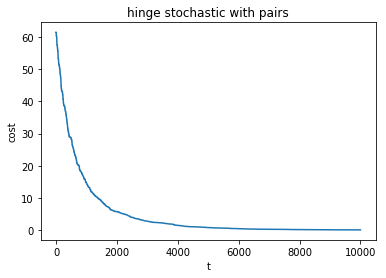

Nb de valeurs propres de M egales a 0:  69 / 150


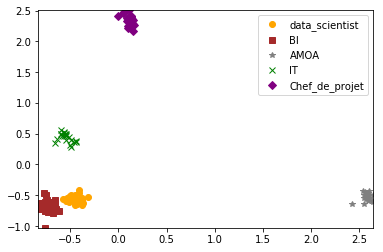

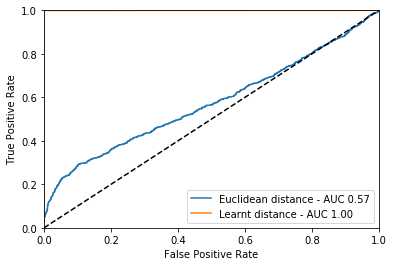

knn score based on M distance 1.0
classes: [1 2 4 6 7]
classe y: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
classes predites y: [1 1 1 1 1 1 6 1 1 1 1 1 1 1 6 1 1 1 1 1 6 1 2 6 6 1 1 6 2 2 2 2 1 7 6 2 1
 1 1 6 6 6 1 1 2 6 6 1 6 1 1 4 6 6 4 7 1 6 1 1 1 1 2 7 6 7 4 6 1 6 6 4 1 6
 1 4 6 6 7 4 7 7 7 6 1 6 1 4 1]
KNN model: 127 labeled & 89 unlabeled points (216 total)
             precision    recall  f1-score   support

          1       0.34      0.88      0.49        16
          2       0.88      0.23      0.37        30
          4       0.29      0.14      0.19        14
          6       0.20      0.33      0.25        15
          7       0.50      0.29      0.36        14

avg / total       0.51      0.36      0.34        89

Confusion matrix
[[14  0  0  2  0]
 [13  7  0  9  1]
 [ 6  0  2  5  1]
 [ 5  1  2  5  2]
 [ 3  0  3  4  4]]


In [222]:

column_names_talan = df_cv_talan_label.columns.values[:-2].tolist()
#X = df_target_lsa_talan[column_names_talan][df_target_lsa_talan['CV_Label'] !=-1].values

#X = df_target_lsa_talan[column_names_talan].values
X = df_cv_talan_label[column_names_talan].values
y = df_cv_talan_label.CV_Label.values
#y = df_target_lsa_talan['CV_Label'][df_target_lsa_talan['CV_Label'] !=-1].values
#y = df_target_lsa_talan['CV_Label'].values
print("shape X:", X.shape)
print( "shape y:", y.shape)

np.unique(y)

clf = trainEval_MetricLearning_balancedClasses(X,y,0.6)
#X= X.astype(np.float)
#X.std()


# Approche basée sur les triplets

In [130]:
def hinge_loss_triplets(X, triplets_idx, M):
    """Calcul du hinge loss sur les triplets
    """
    diffp = X[triplets_idx[:, 0], :] - X[triplets_idx[:, 1], :]
    diffn = X[triplets_idx[:, 0], :] - X[triplets_idx[:, 2], :]
    return np.maximum(0., 1. - np.sum(np.dot(M, diffn.T) * diffn.T, axis=0) +
                      np.sum(np.dot(M, diffp.T) * diffp.T, axis=0))


def generate_triplets(X, y, n_triplets, random_state=42):
    """Generation de triplets
    """
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]
    triplets_idx = np.zeros((n_triplets, 3), dtype=int)
    triplets_idx[:, 0] = rng.randint(0, n_samples, (n_triplets,))
    for i in range(n_triplets):
        same_idx = np.where(y == y[triplets_idx[i, 0]])[0]
        diff_idx = np.where(y != y[triplets_idx[i, 0]])[0]
        triplets_idx[i, 1] = same_idx[rng.randint(0, same_idx.shape[0])]
        triplets_idx[i, 2] = diff_idx[rng.randint(0, diff_idx.shape[0])]
    return triplets_idx


def sgd_metric_learning_triplets(X, y, gamma, alpha, n_iter, n_eval, M_ini,
                                 random_state=42):
    """Stochastic gradient algorithm for metric learning with triplets

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The labels.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    alpha : float
        The regularization parameter
    n_iter : int
        The number of iterations
    n_eval : int
        The number of triplets to evaluate the objective function
    M_ini : array, shape (n_features,n_features)
        The initial value of M
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape
    # generate n_eval triplets
    triplets_idx = generate_triplets(X, y, n_eval, random_state=random_state)
    M = M_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        pobj[t] = np.mean(hinge_loss_triplets(X, triplets_idx, M)
                          ) + alpha * np.trace(M)
        idx = generate_triplets(X, y, 1, random_state=random_state + t)[0]
        diffp = X[idx[0], :] - X[idx[1], :]
        diffn = X[idx[0], :] - X[idx[2], :]
        gradient = (np.outer(diffp, diffp) - np.outer(diffn, diffn)) * (
            1. - np.dot(diffn, M.dot(diffn.T)) + np.dot(diffp,
                                                        M.dot(diffp.T)) > 0)
        gradient += alpha * np.eye(n_features)
        M -= gamma_func(t) * gradient
        M = psd_proj(M)
    return M, pobj



In [224]:
df_cv_talan_label

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,CV_name,CV_Label
0,0.43749416833497257,-0.1456086306524653,-0.07774435720110606,-0.13363334730081416,-0.033845912180408166,0.026451134756935234,0.06398435837088359,-0.047682382648373565,-0.19782358627418137,0.25417653200025864,...,-0.007984725266895202,0.016216271876592456,-0.04294975374873885,-0.01708034134912778,-0.0368726083156249,0.10389845717758377,-0.0075152242229512434,0.10757290811440756,ACH.txt,7
1,0.3822585985977701,-0.010495121810849451,0.2355470380862648,-0.029682957657193927,0.03221433598588246,0.16840714013308075,-0.056627652132423816,-0.05980372996240239,0.10839974477637933,-0.07483771841651693,...,-0.061185524295443224,-0.015374500432209063,0.026914702779666507,0.04614192390143483,-0.08751403455753753,0.08482433182516497,0.015563197365539447,-0.023786339568587563,ADD.txt,2
2,0.3330940845516005,-0.09124634490380856,-0.2058612692743384,-0.05552178674532244,-0.038464469766951274,0.05489025353325966,0.011837495860531122,0.02517690860037287,-0.09383092764765696,-0.05168911791864637,...,-0.0033651427039334135,-0.03428044391459208,0.05324923688917103,-0.03005485449783079,-0.037048507045944486,0.020616614860104552,0.014864010771028948,0.007343356049352175,ADECV TALAN.txt,6
3,0.2518293104882994,-0.08486803705429512,-0.18677123682950422,-0.12696627988993536,-0.008612197186843255,0.06596583186710825,-0.007267836373113465,0.011316462233973455,-0.024079979156764394,-0.07316545086162729,...,-2.7249541135527307e-05,-0.00848283979002415,0.01269642737705823,0.016219508267819066,0.028601837671936733,-0.0007687636564024983,-0.08662590062108097,0.003316325984994827,AGNCV TALAN.txt,6
4,0.3937791459654183,-0.06965221653604456,0.03236510933384413,0.10809080617894684,-0.22296620339170845,0.12631175370011086,-0.2215723234728932,-0.09390024079327193,0.04415365124658832,-0.09412624473822069,...,0.05703067994386529,-0.022042154011734514,-0.051670133111038866,-0.011165425805296425,0.03389695097736884,0.028255565057840604,0.015070297835276662,0.03522626504604949,AIT.txt,2
5,0.4229720107964742,-0.16822793445218254,-0.25058292165930673,-0.14384737291351965,-0.15387237393683156,0.13437201130757628,-0.04131390247194301,0.013383870143798755,0.05767868915092028,-0.1062069339460714,...,0.03943710470629607,-0.06480336754357498,-0.03968061957317279,-0.06546712456950113,-0.003959001332378006,-0.0004697456724828461,0.06134270321111804,0.043556152571952944,AKACV TALAN.txt,4
6,0.5972260710789097,-0.09612897884065127,0.24393209710236882,0.11976684106310657,-0.08551374733659593,-0.08813694818022745,-0.14438056427365828,0.15912250101094713,0.05550430369081318,0.08385832092039934,...,0.007870559637006532,0.017621858226817225,-0.03952569017421783,-0.1021291968719888,-0.10424560908976252,0.042677093170348554,-0.010133047576419694,0.05097978494144905,AME.txt,2
7,0.43822232928559923,-0.19553877737063513,0.31726713199183065,0.14670383875476517,-0.27295069608947625,-0.10780807923014485,0.22987159052791412,-0.21759987186894597,0.03896179508431935,-0.15519165461813017,...,0.020666402120154817,0.008102460634446192,-0.03053965351048987,-0.0014416708428612389,0.07605636831732938,-0.016450632266992678,-0.017789253568193605,-0.009584157023846606,ANDA.txt,6
8,0.2845878137989621,-0.11978291757519804,-0.16548265447343066,-0.1332722986903071,-0.1100240623839734,0.12202568751603145,-0.009005309660933644,0.0663700413255467,-0.06654664673036591,0.002228923111810001,...,0.0029600788577174146,-0.027234205469778772,-0.03223812814116667,0.01732198939461527,0.027903939290778168,9.291451589381294e-05,-0.02613249199723025,-0.040942536220143336,APHCV TALAN.txt,6
9,0.48271609993086223,-0.2015886271480232,-0.3244075919707594,-0.1069500465951725,-0.006757697341676045,0.07461428283011333,-0.009032725464442873,0.07882932046198252,0.1827312978601241,-0.1706629615349098,...,0.036333454661342746,0.010118965536366663,0.08466020478445498,0.04498195080260118,0.033400953950579515,0.004623887696121419,-0.07051400481598794,-0.0520552723160759

shape X: (216, 150)
shape y: (216,)


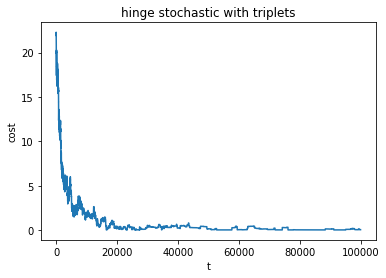

Nb de valeurs propres de M egales a 0:  1 / 150


In [158]:

column_names_talan = df_cv_talan_label.columns.values[:-2].tolist()
#X = df_target_lsa_talan[column_names_talan][df_target_lsa_talan['CV_Label'] !=-1].values

#X = df_target_lsa_talan[column_names_talan].values
X = df_cv_talan_label[column_names_talan].values
y = df_cv_talan_label.CV_Label.values
#y = df_target_lsa_talan['CV_Label'][df_target_lsa_talan['CV_Label'] !=-1].values
#y = df_target_lsa_talan['CV_Label'].values
print("shape X:", X.shape)
print( "shape y:", y.shape)

X= X.astype(np.float)
y= y.astype(np.float)
# standardize data
X -= X.mean(axis=0)
X /= X.std(axis=0)

n_features = X.shape[1]
M_ini = np.eye(n_features)
M, pobj = sgd_metric_learning_triplets(X, y, 0.001, 0.0001, 100000, 100, M_ini)

plt.figure()
plt.plot(pobj)
plt.xlabel('t')
plt.ylabel('cost')
plt.title('hinge stochastic with triplets')
plt.show()

# check number of nonzero eigenvalues
e, v = np.linalg.eig(M)
print("Nb de valeurs propres de M egales a 0: ", np.sum(e < 1e-12), "/", e.shape[0])

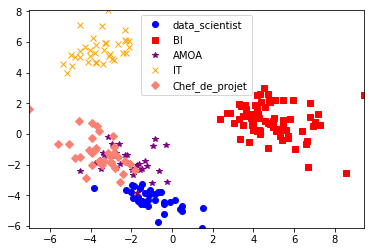

In [160]:
# calcul de la factorisation de cholesky
# on ajoute de tres faibles coefficients sur la diagonale pour eviter
# les erreurs numeriques
L = np.linalg.cholesky(M + 1e-10 * np.eye(n_features))
# on projette lineairement les donnees
X_proj = np.dot(X, L)

# on utilise PCA pour projeter les donnees en 2D
pca = decomposition.PCA(n_components=2)
X_proj_2D = pca.fit_transform(X_proj)

plot_2d(X_proj_2D, y)

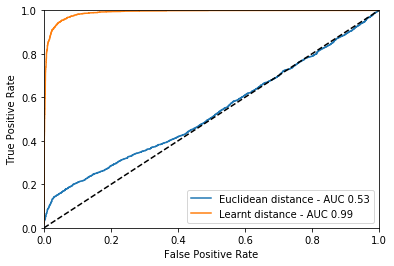

In [161]:
# on tire 10000 paires aleatoires et on calcule les distances
y_pairs, dist_euc, dist_M = distances_random_pairs(X, y, M, n_pairs=10000)

fpr_M, tpr_M, thresh_M = roc_curve(y_pairs, -dist_M)
fpr_euc, tpr_euc, thresh_euc = roc_curve(y_pairs, -dist_euc)
auc_M = auc(fpr_M, tpr_M)


auc_euc = auc(fpr_euc, tpr_euc)

# plot ROC curves
plt.figure()
plt.plot(fpr_euc, tpr_euc, label='Euclidean distance - AUC %.2f' % auc_euc)
plt.plot(fpr_M, tpr_M, label='Learnt distance - AUC %.2f' % auc_M)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Evaluation KNN basé sur la distance apprise

In [194]:
def trainEval_MetricLearningTriplets_balancedClasses(data,target,percent_test):
   
    indice_labelized_train, indice_unlabelized_train = get_indices_TrainSet_metric(data, target, percent_test)
    X = data
    y = target
    X = X.astype(np.float)
    y = y.astype(np.int)
    print("y classes unique:", np.unique(y))
    
    n_labeled_points = indice_labelized_train.shape[0]
    n_total_samples = indice_labelized_train.shape[0] + indice_unlabelized_train.shape[0]

    X_train = X[indice_labelized_train]
    y_train = y[indice_labelized_train]
    print("y_train classes unique:", np.unique(y_train))
    X_test =  X[indice_unlabelized_train]
    y_test =  y[indice_unlabelized_train]
    
    print("y_test classes unique:", np.unique(y_test))
    #y_train[indice_unlabelized_train] = -1
    #y_train[y_train !=-1].shape
    
   # X_train= X_train.astype(np.float)
   # y_train = y_train.astype(np.float)
# standardize data
    X_train -= X_train.mean(axis=0)
    X_train /= X_train.std(axis=0)
    
    X_test -= X_test.mean(axis=0)
    X_test /= X_test.std(axis=0)
    
    n_features = X_train.shape[1]

    M_ini = np.eye(n_features)
    M, pobj = sgd_metric_learning_triplets(X, y, 0.01, 0.01, 100000, 100, M_ini)
    # alpha = 0.01, gamma = 0.001 pour 50% des données ca donne une courbe de ROC de 0.99 et un score de 0.77

    plt.figure()
    plt.plot(pobj)
    plt.xlabel('t')
    plt.ylabel('cost')
    plt.title('hinge stochastic with pairs')
    plt.show()

# on regarde le nombre de valeurs propres egales a 0
    e, v = np.linalg.eig(M)
    print("Nb de valeurs propres de M egales a 0: ", np.sum(e < 1e-12), "/", e.shape[0])
   # on ajoute de tres faibles coefficients sur la diagonale pour eviter

# les erreurs numeriques
    L = np.linalg.cholesky(M + 1e-10 * np.eye(n_features))
# on projette lineairement les donnees
    X_proj = np.dot(X_train, L)

# on utilise PCA pour projeter les donnees en 2D

    pca = decomposition.PCA(n_components=2)
    X_proj_2D = pca.fit_transform(X_proj)

    plot_2d(X_proj_2D, y_train)
    
        # on tire 10000 paires aleatoires et on calcule les distances
    y_pairs, dist_euc, dist_M = distances_random_pairs(X_train, y_train, M, n_pairs=10000)

    from sklearn.metrics import roc_curve, auc

    # compute ROC curve for Euclidean distance and Mahalanobis
    fpr_euc, tpr_euc, thresh_euc = roc_curve(y_pairs, -dist_euc)
    fpr_M, tpr_M, thresh_M = roc_curve(y_pairs, -dist_M)

    # compute AUC for Euclidean distance and Mahalanobis
    auc_euc = auc(fpr_euc, tpr_euc)
    auc_M = auc(fpr_M, tpr_M)

    # plot ROC curves
    plt.figure()
    plt.plot(fpr_euc, tpr_euc, label='Euclidean distance - AUC %.2f' % auc_euc)
    plt.plot(fpr_M, tpr_M, label='Learnt distance - AUC %.2f' % auc_M)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    n_neighbors = 7
    clf = KNeighborsClassifier(n_neighbors)


    score = cross_val_score(clf, X_proj, y_train, cv=5)
    print("knn score based on M distance", np.mean(score))

    clf.fit(X_proj_2D,y_train)
    
    X_test_proj = np.dot(X_test, L)
    
    X_test_proj_2D = pca.transform(X_test_proj)
    
    predicted_labels = clf.predict(X_test_proj_2D)
    true_labels = y_test
    
    print("classes:" , clf.classes_)
    print("classe y:", y_test)
    print("classes predites y:", predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels, labels=clf.classes_)

    print("KNN model: %d labeled & %d unlabeled points (%d total)" %
              (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)
    return clf,cm



shape X: (216, 150)
shape y: (216,)
y classes unique: [1 2 4 6 7]
y_train classes unique: [1 2 4 6 7]
y_test classes unique: [1 2 4 6 7]


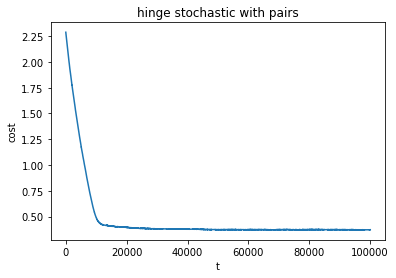

Nb de valeurs propres de M egales a 0:  101 / 150


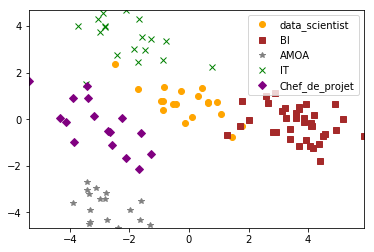

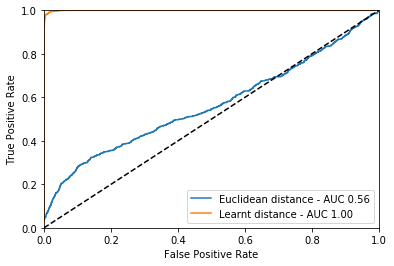

knn score based on M distance 1.0
classes: [1 2 4 6 7]
classe y: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
classes predites y: [1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 7 4 4 4 4 4 4 4 4 4 4 4
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 4 7 4 7 7 4 4 7 7 7 7 7 7 7 7 7]
KNN model: 107 labeled & 109 unlabeled points (216 total)
             precision    recall  f1-score   support

          1       1.00      0.85      0.92        20
          2       0.93      1.00      0.96        37
          4       0.80      0.94      0.86        17
          6       1.00      1.00      1.00        18
          7       0.93      0.76      0.84        17

avg / total       0.93      0.93      0.93       109

Confusion matrix
[[17  3  0  0  0]
 [ 0

In [223]:
column_names_talan = df_cv_talan_label.columns.values[:-2].tolist()
#X = df_target_lsa_talan[column_names_talan][df_target_lsa_talan['CV_Label'] !=-1].values

#X = df_target_lsa_talan[column_names_talan].values
X = df_cv_talan_label[column_names_talan].values
y = df_cv_talan_label.CV_Label.values
#y = df_target_lsa_talan['CV_Label'][df_target_lsa_talan['CV_Label'] !=-1].values
#y = df_target_lsa_talan['CV_Label'].values
print("shape X:", X.shape)
print( "shape y:", y.shape)

np.unique(y)

clf,cm = trainEval_MetricLearningTriplets_balancedClasses(X,y,0.5)

Confusion matrix, without normalization
[[17  3  0  0  0]
 [ 0 37  0  0  0]
 [ 0  0 16  0  1]
 [ 0  0  0 18  0]
 [ 0  0  4  0 13]]
Normalized confusion matrix
[[ 0.85  0.15  0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.94  0.    0.06]
 [ 0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.24  0.    0.76]]


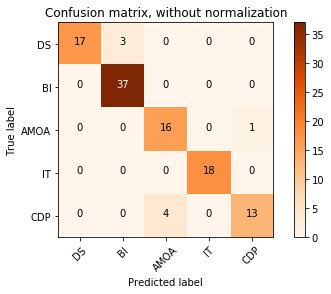

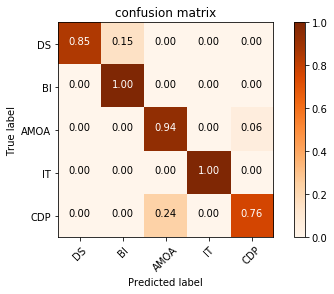

In [214]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Compute confusion matrix

np.set_printoptions(precision=2)
class_names = ["DS","BI","AMOA","IT","CDP"]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='confusion matrix')

plt.show()

### Classofication avec Knn en utilisant la distance apprise

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

n_neighbors = 7
clf = KNeighborsClassifier(n_neighbors)


score = cross_val_score(clf, X_proj, y, cv=5)
print("knn score based on M distance", np.mean(score))

score = cross_val_score(clf, X, y, cv=5)
print("knn score based on Euclidean distance", np.mean(score))

clf.fit(X_proj,y)


In [ ]:
print(cv_classeName)

In [ ]:
column_names_talan = df_cv_talan_label.columns.values[:-2].tolist()
X_to_pred = df_target_lsa[column_names_talan][df_target_lsa['CV_Label'] == 3].values
#y_true = df_target_lsa.CV_Label.values
X_to_pred= X_to_pred.astype(np.float)
# on projette lineairement les donnees
X_to_predict = np.dot(X_to_pred, L)
X_to_predict


In [ ]:
neighbors = clf.kneighbors(X_to_predict,return_distance=True)
neighbors

In [ ]:
neighbors[1][:,0:1]

In [ ]:
 df_cv_talan_label.loc[91]['CV_Label']

In [ ]:
df_target_lsa['CV_name'][df_target_lsa['CV_Label'] == 3]